# TF-IDF + Passive-Aggressive Classifier Pipeline + Extra Engineered Features + Hyperparameter Optimization

## Environment Setup

In [1]:
import os
# Imports the basic data processing and functionality libraries
import pandas as pd
import numpy as np
# Monitors the preprocessing pandas progress 
from tqdm import tqdm 
tqdm.pandas()
import random
# Regular expressions
import re
# For timing how long operations take
import time
# For saving and loading machine-learning models
import joblib
# For loading in saved hyperparameters, default - they are being saved and loaded as OrderedDict instead of dicts
from collections import OrderedDict

# Imports and downloads required nltk libraries for text processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("stopwords")
# Creates set out of English stopwords
stop_words = set(stopwords.words('english'))
# For POS-tag extraction and named entity extraction
import spacy
# Emotion lexicon for 8 categories of emotions
from nrclex import NRCLex
# Textstat for extracting readability scores
import textstat

# Imports the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Imports the machine learning (scikit-learn) model training tools
from sklearn.feature_extraction.text import TfidfVectorizer
 # Combines TF-IDF vectors with extra features derived using feat engineering techniques
from sklearn.compose import ColumnTransformer
# Scales all features to same range
from sklearn.preprocessing import StandardScaler 
# Combines TF-IDF & Passive Aggressive Classifier
from sklearn.pipeline import Pipeline 
# Wraps Passive-Aggressive Classifier for prediction probabilities
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.linear_model import PassiveAggressiveClassifier
# Imports eval metrics
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score, precision_score, recall_score, classification_report

# Uses scikit-learn optimization lib instead of GridSearchCV for larger "smarter" and more efficient search of hyperparameter space
# Reference: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
# "In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from 
# the specified distributions. The number of parameter settings that are tried is given by n_iter." GridSearchCV would 
# take TOO LONG for the 100k+ hyperparam combos required to optimize this model for each dataset.
from skopt import BayesSearchCV
# Data types for passing in the hyperparameter types and ranges into BayesSearchCV
from skopt.space import Real, Integer, Categorical

[nltk_data] Downloading package wordnet to /Users/ophelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ophelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loads in all of the training datasets for feature extraction

###################################### LOADS IN FULL-SCALE (Single Dataset) TRAINING DATA ###########################################################
# Validation sets are not included in this training data, only training data is - to prevent data leakage
wf_train_df = pd.read_csv("../FPData/WELFake/clean_train_wf.csv") # WELFake
fe_train_df = pd.read_csv("../FPData/Fakeddit/clean_train.csv") # Fakeddit
ct_train_df = pd.read_csv("../FPData/Constraint/clean_train.csv") # Constraint
pf_train_df = pd.read_csv("../FPData/PolitiFact/clean_train_pf.csv") # PolitiFact
gc_train_df = pd.read_csv("../FPData/GossipCop/clean_train_gc.csv") # GossipCop


# Loads in the validation sets
wf_val_df = pd.read_csv("../FPData/WELFake/clean_val_wf.csv") # WELFake
fe_val_df = pd.read_csv("../FPData/Fakeddit/clean_val.csv") # Fakeddit
ct_val_df = pd.read_csv("../FPData/Constraint/clean_val.csv") # Constraint
pf_val_df = pd.read_csv("../FPData/PolitiFact/clean_val_pf.csv") # PolitiFact
gc_val_df = pd.read_csv("../FPData/GossipCop/clean_val_gc.csv") # GossipCop


# Loads in the test sets
wf_test_df = pd.read_csv("../FPData/WELFake/clean_test_wf.csv") # WELFake
fe_test_df = pd.read_csv("../FPData/Fakeddit/clean_test.csv") # Fakeddit
ct_test_df = pd.read_csv("../FPData/Constraint/clean_test.csv") # Constraint
pf_test_df = pd.read_csv("../FPData/PolitiFact/clean_test_pf.csv") # PolitiFact
gc_test_df = pd.read_csv("../FPData/GossipCop/clean_test_gc.csv") # GossipCop


###################################### LOADS IN FIVE-SHOT TRAINING DATA ######################################################################
# Target: WELFake
five_shot_wf_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_welfake.csv") 
# Target: Constraint
five_shot_ct_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_constraint.csv") 
# Target: PolitiFact
five_shot_pf_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_politifact.csv") 
# Target: GossipCop
five_shot_gc_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_gossipcop.csv") 


###################################### LOADS IN ZERO-SHOT TRAINING DATA ######################################################################
# Target: WELFake
zero_shot_wf_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_welfake.csv") 
# Target: Constraint
zero_shot_ct_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_constraint.csv") 
# Target: PolitiFact
zero_shot_pf_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_politifact.csv") 
# Target: GossipCop
zero_shot_gc_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_gossipcop.csv")

########################################## LOADS IN THE ALL-FOUR DATASETS ################################################################
# All four text-only datsets combined
all_four_datasets_train_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_training_sets_combined.csv")
all_four_datasets_val_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_val_sets_combined.csv")
all_four_datasets_test_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_test_sets_combined.csv")

## Selected Semantic and Linguistic Feature Extraction

In [18]:
class BasicFeatureExtractor:
    
    """
        A class containing methods for extracting the identified discriminative features for 
        helping a machine-learning based classifier categorize real and fake news, including features such as
        normalized (by text length in word tokens) exclamation point count, third person pronoun frequency and PERSON
        named entity frequency counts.
    """

    
    def __init__(self):
        # Loads in the SpaCy large English model for extracting named entities
        self.nlp = spacy.load("en_core_web_lg")
        print("Finished loading large SpaCy model!")


    def extractExclamationPointFreqs(self, text):
        """
        A helper method that extracts the frequencies of exclamation points from a news text. 
        To be applied using .apply or .progress_apply to a "text" column in a news DataFrame
        
            Input Parameters:
                text (str): the news text to extract exclamation point frequencies from
    
            Output:
                excl_point_freq (float): the normalized exclamation point frequency for the text.
                Normalized by num of word tokens to handle varying text length datasets
        """
        # Counts the number of exclamation points in the text
        exclamation_count = text.count('!')
        
        # Tokenizes the text for calculating text length
        word_tokens = word_tokenize(text)
        
        # Calculates the text length in number of word tokens
        text_length = len(word_tokens)
        
        # Normalizes the exclamation point frequency
        return exclamation_count / text_length if text_length > 0 else 0 # Handle division-by-zero errs


    def extractThirdPersonPronounFreqs(self, text):
        """
        Extracts the normalized frequency counts of third-person pronouns in the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract pronoun features from.
            
            Output:
                float: Normalized third-person pronoun frequency.
        """
        
        # Creates a list of all the English third-person pronouns
        third_person_pronouns = [
            "he","he'd", "he's", "him", "his",
            "her", "hers", 
            "it", "it's", "its",
            "one", "one's", 
            "their", "theirs", "them","they", "they'd", "they'll", "they're", "they've",   
            "she", "she'd", "she's"
        ]

        
        # Tokenizes the text for calculating text length
        word_tokens = word_tokenize(text)
        
        # Calculates the text length in number of word tokens
        text_length = len(word_tokens)

        # Counts the frequency of third-person pronouns in the news text, lowercases text to match the list of third-person pronouns above
        third_person_count = sum(1 for token in word_tokens if token.lower() in third_person_pronouns)

        # Normalizes the frequency by text length in word tokens
        return third_person_count / text_length if text_length > 0 else 0



    def extractNounToVerbRatios(self, text):
        """
        Calculates the ratio of all types of nouns to all types of verbs in the text
        using the Penn Treebank POS Tagset and the SpaCy library with the downloaded
        "en_core_web_lg" model.
        
            Input Parameters:
                text (str): the news text to extract noun-verb ratio features from.
            
            Output:
                float: Noun-to-verb ratio, or 0.0 if no verbs are present.
        """
        
        # Converts the text to an NLP doc object using the SpaCy library.
        doc = self.nlp(text)
        
        # Defines Penn Treebank POS tag categories for diff kinds nouns and verbs
        # Reference: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
        noun_tags = ["NN", "NNS", "NNP", "NNPS"]
        verb_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
        
        # Counts nouns and verbs in this text based on the above stored Penn Treebank tags
        noun_count = sum(1 for token in doc if token.tag_ in noun_tags)
        verb_count = sum(1 for token in doc if token.tag_ in verb_tags)
        
        # Computes and returns the noun-to-verb ratio (should be higher for fake news, more nouns)
        return noun_count / verb_count if verb_count > 0 else 0.0 # Avoid division-by-zero error


    def extractCARDINALNamedEntityFreqs(self, text):
        """
        Extracts the normalized frequency of CARDINAL named entities in the text
        using the SpaCy library.
        
            Input Parameters:
                text (str): The text to extract the CARDINAL named entity frequencies from.
            
            Output:
                float: Normalized frequency (by number of tokens in the text) of CARDINAL named entities.
        """
        # Processes the text with SpaCy to get NLP doc object
        doc = self.nlp(text)
        
         # Counts how many named entities have the label "CARDINAL"
        cardinal_entity_count = sum(1 for entity in doc.ents if entity.label_ == "CARDINAL")

        # Tokenizes the text
        word_tokens = [token for token in doc]
        
        # Counts the number of word tokens in the text
        text_length = len(word_tokens)

        # Returns the normalized frequency of CARDIAL named entities
        return cardinal_entity_count / text_length if text_length > 0 else 0.0 # Avoid division-by-zero error


    def extractPERSONNamedEntityFreqs(self, text):
        """
        Extracts the normalized frequency of PERSON named entities in the text
        using the SpaCy library.
        
            Input Parameters:
                text (str): The text to extract the PERSON named entity frequencies from.
            
            Output:
                float: Normalized frequency (by number of tokens in the text) of PERSON named entities.
        """
        
        # Processes the text with SpaCy to get NLP doc object
        doc = self.nlp(text)
        
        # Counts how many named entities have the label "PERSON"
        person_entity_count = sum(1 for entity in doc.ents if entity.label_ == "PERSON")
        
        # Tokenizes the text
        word_tokens = [token for token in doc]
        
        # Counts number of word tokens in the text
        text_length = len(word_tokens)
        
        # Returns the normalized frequency of PERSON named entities
        return person_entity_count / text_length if text_length > 0 else 0.0 # Avoids division-by-zero error


    def extractPositiveNRCLexiconEmotionScore(self, text):
        """
        Extracts the POSITIVE emotion score using the NRC Lexicon from the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract POSITIVE emotion score from.
            
            Output:
                float: POSITIVE emotion score.
        """
        # Lowercases the text to match lexicon entries
        text = text.lower()
        
        # Creates an NRC Emotion Lexicon object
        emotion_obj = NRCLex(text)
        
        # Returns the POSITIVE emotion score (use "get" to default to 0.0 if for some reason it is not found)
        return emotion_obj.affect_frequencies.get("positive", 0.0) 


    def extractTrustNRCLexiconEmotionScore(self, text):
        """
        Extracts the TRUST emotion score using the NRC Lexicon from the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract TRUST emotion score from.
            
            Output:
                float: TRUST emotion score.
        """
        # Lowercases the text
        text = text.lower()
        
        # Creates an NRC Emotion Lexicon object
        emotion_obj = NRCLex(text)
        
        # Returns the TRUST emotion score (use "get" to default to 0.0 if for some reason it is not found)
        return emotion_obj.affect_frequencies.get("trust", 0.0)


    def extractFleschKincaidGradeLevel(self, text):
        """
        Extracts Flesch-Kincaid Grade Level score for the inputted text.
        
            Input Parameters:
                text (str): the news text for which want to calculate the Flesch-Kincaid Grade Level score.
            
            Output:
                float: the Flesch-Kincaid Grade Level score for the text.
        """
        return textstat.flesch_kincaid_grade(text)
        
        
    def extractDifficultWordsScore(self, text):
        """
        Extracts num. of difficult words in the inputted text using the textstat lib.
        
        Input Parameters:
            text (str): the news text to calculate the difficult words score.
        
        Output:
            float: the number of difficult words score for the text.
        """
        
        text = text.lower()
        
        return textstat.difficult_words(text)
        

    def extractCapitalLetterFreqs(self, text):
        """
        Extracts the normalized frequency of capital letters in the input text.
        Normalized by the total number of tokens to account for varying text lengths.
    
            Input Parameters:
                text (str): The news text to extract capital letter frequencies from.
            
            Output:
                float: Normalized frequency of capital letters in the text.
        """
        # Counts the number of capital letters in the text
        capital_count = sum(1 for char in text if char.isupper())
        
        # Tokenizes the text
        word_tokens = word_tokenize(text)

        # Counts the number of word tokens in the text
        text_length = len(word_tokens)
        
        # Normalizes the frequency of capital letters
        return capital_count / text_length if text_length > 0 else 0.0 # Avoids division-by-zero error
        
    
    def extractBasicFeatures(self, df, dataset_name, root_save_path="../FPData/BasicFeatureExtractionDFs"):
        """
        Adds new columns to an inputted DataFrame that stores the frequency of 
        or score for various features derived from the "text" column, hopefully for 
        improved classification performance using a Passive Aggressive Classifier model.

            Input Parameters:
                df (pd.DataFrame): DataFrame with a "text" column containing news texts.
    
            Output:
                pd.DataFrame: a new DataFrame with the additional feature columns
        """
        # Creates a copy of the original DataFrame to store new features in
        basic_feature_df = df.copy()

        # Extracts the dataset name without the ".csv" at the end to print out dataset name being processed
        dataset_name_without_csv_extension = dataset_name.split('.')[0]
        print(f"Extracting features for {dataset_name_without_csv_extension}...")
        
        # Applies the exclamation point frequency helper function...
        print("Extracting normalized exclamation point frequencies...")
        basic_feature_df["exclamation_point_frequency"] = basic_feature_df["text"].progress_apply(self.extractExclamationPointFreqs)
        
        # Applies the third-person pronoun frequency helper function...
        print("Extracting third person pronoun frequencies...")
        basic_feature_df["third_person_pronoun_frequency"] = basic_feature_df["text"].progress_apply(self.extractThirdPersonPronounFreqs)

        # Applies the noun-to-verb ratio helper functionn
        print("Extracting noun-to-verb ratio frequencies...")
        basic_feature_df["noun_to_verb_ratio"] = basic_feature_df["text"].progress_apply(self.extractNounToVerbRatios)

        # Applies the CARDINAL named entity frequency helper function to create a new column
        print("Extracting CARDINAL named entity frequencies...")
        basic_feature_df["cardinal_named_entity_frequency"] = basic_feature_df["text"].progress_apply(self.extractCARDINALNamedEntityFreqs)

        # Applies the PERSON named entity frequency helper function to create a new column
        print("Extracting PERSON named entity frequencies...")
        basic_feature_df["person_named_entity_frequency"] = basic_feature_df["text"].progress_apply(self.extractPERSONNamedEntityFreqs)

        # Applies the NRC Lexicon to get the POSITIVE emotion scores for each text
        print("Extracting NRC Lexicon POSITIVE emotion scores...")
        basic_feature_df["nrc_positive_emotion_score"] = basic_feature_df["text"].progress_apply(self.extractPositiveNRCLexiconEmotionScore)

        # Applies the NRC Lexicon to get the TRUST emotion scores for each text
        print("Extracting NRC Lexicon TRUST emotion scores...")
        basic_feature_df["nrc_trust_emotion_score"] = basic_feature_df["text"].progress_apply(self.extractTrustNRCLexiconEmotionScore)

        # Applies textstat package to get the Flesch-Kincaid U.S. Grade Level readability score
        print("Extracting Flesch-Kincaid U.S. Grade readability scores...")
        basic_feature_df["flesch_kincaid_readability_score"] = basic_feature_df["text"].progress_apply(self.extractFleschKincaidGradeLevel)

        # Applies the textstat package to get the difficult_words readability score
        print("Extracting difficult words readability scores...")
        basic_feature_df["difficult_words_readability_score"] = basic_feature_df["text"].progress_apply(self.extractDifficultWordsScore)

        # Extracts counts of capital letters for each text normalized by number of tokens
        print("Extracting normalized capital letter frequency scores..")
        basic_feature_df["capital_letter_frequency"] = basic_feature_df["text"].progress_apply(self.extractCapitalLetterFreqs)

        # Saves the dataset with extracted features to disk
        basic_feature_df.to_csv(os.path.join(root_save_path, dataset_name), index=False)
        
        return basic_feature_df

    def extractExtraFeaturesColumns(self, df):
        """
        Extracts the engineered features featuresets only from the DataFrame, exclude the other columns.

            Input Parameters:
                df (pd.DataFrame): news dataset to extract the engineered features from
            Output:
                pd.DataFrame: the extracted engineered feature columns from the DataFrame that was passed in
        """
        return df[[
        "exclamation_point_frequency", "third_person_pronoun_frequency", "noun_to_verb_ratio",
        "cardinal_named_entity_frequency", "person_named_entity_frequency", 
        "nrc_positive_emotion_score", "nrc_trust_emotion_score", 
        "flesch_kincaid_readability_score", "difficult_words_readability_score", 
        "capital_letter_frequency"
    ]] 

In [19]:
# Creates an instance of the basic feature extractor
basic_feat_extractor = BasicFeatureExtractor()

Finished loading large SpaCy model!


In [12]:
# Times how long feature extraction for all the six full-scale dsets takes
start_time_fullscale = time.time()

# Extracts and saves the selected features for the full-scale train (and val) sets

# WELFake
wf_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    wf_train_df,
    "WELFake_train_basic_features.csv"
)
wf_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    wf_val_df,
    "WELFake_val_basic_features.csv"
)


# Fakeddit
fe_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    fe_train_df,
    "Fakeddit_train_basic_features.csv"
)
fe_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    fe_val_df,
    "Fakeddit_val_basic_features.csv"
)

# Constraint
ct_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    ct_train_df,
    "Constraint_train_basic_features.csv"
)
ct_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    ct_val_df,
    "Constraint_val_basic_features.csv"
)

# PolitiFact
pf_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    pf_train_df,
    "PolitiFact_train_basic_features.csv"
)
pf_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    pf_val_df,
    "PolitiFact_val_basic_features.csv"
)

# GossipCop
gc_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    gc_train_df,
    "GossipCop_train_basic_features.csv"
)
gc_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    gc_val_df,
    "GossipCop_val_basic_features.csv"
)

end_time_fullscale = time.time()

time_elapsed_fullscale = end_time_fullscale - start_time_fullscale

print(f"Time in seconds elapsed for extracting features for full-scale train and val sets: {time_elapsed_fullscale}")

Extracting features for WELFake_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 41560/41560 [00:51<00:00, 809.93it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 41560/41560 [00:55<00:00, 753.97it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 41560/41560 [48:09<00:00, 14.38it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 41560/41560 [47:53<00:00, 14.47it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 41560/41560 [48:10<00:00, 14.38it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 41560/41560 [01:26<00:00, 479.30it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 41560/41560 [01:27<00:00, 474.46it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 41560/41560 [00:20<00:00, 2001.62it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 41560/41560 [00:15<00:00, 2661.86it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 41560/41560 [00:54<00:00, 765.56it/s]

Extracting features for WELFake_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|██████████████████████████████████████| 9325/9325 [00:11<00:00, 806.38it/s]

Extracting third person pronoun frequencies...



00%|██████████████████████████████████████| 9325/9325 [00:12<00:00, 743.70it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████████| 9325/9325 [10:56<00:00, 14.20it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████████| 9325/9325 [10:47<00:00, 14.40it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████████| 9325/9325 [10:48<00:00, 14.38it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|██████████████████████████████████████| 9325/9325 [00:19<00:00, 472.69it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|██████████████████████████████████████| 9325/9325 [00:19<00:00, 471.90it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|█████████████████████████████████████| 9325/9325 [00:04<00:00, 2209.66it/s]

Extracting difficult words readability scores...



00%|█████████████████████████████████████| 9325/9325 [00:03<00:00, 2682.92it/s]

Extracting normalized capital letter frequency scores..



00%|██████████████████████████████████████| 9325/9325 [00:12<00:00, 767.74it/s]

Extracting features for Fakeddit_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████| 648076/648076 [00:20<00:00, 32311.70it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████| 648076/648076 [00:21<00:00, 30040.61it/s]

Extracting noun-to-verb ratio frequencies...



00%|██████████████████████████████████| 648076/648076 [28:54<00:00, 373.62it/s]

Extracting CARDINAL named entity frequencies...



00%|██████████████████████████████████| 648076/648076 [28:39<00:00, 376.92it/s]

Extracting PERSON named entity frequencies...



00%|██████████████████████████████████| 648076/648076 [28:27<00:00, 379.54it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████| 648076/648076 [00:37<00:00, 17216.49it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████| 648076/648076 [00:37<00:00, 17225.79it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████| 648076/648076 [00:08<00:00, 79092.04it/s]

Extracting difficult words readability scores...



00%|████████████████████████████████| 648076/648076 [00:07<00:00, 86037.18it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████| 648076/648076 [00:21<00:00, 30619.95it/s]

Extracting features for Fakeddit_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|██████████████████████████████████| 70332/70332 [00:02<00:00, 32204.67it/s]

Extracting third person pronoun frequencies...



00%|██████████████████████████████████| 70332/70332 [00:02<00:00, 27972.34it/s]

Extracting noun-to-verb ratio frequencies...



00%|████████████████████████████████████| 70332/70332 [03:05<00:00, 379.83it/s]

Extracting CARDINAL named entity frequencies...



00%|████████████████████████████████████| 70332/70332 [03:03<00:00, 383.17it/s]

Extracting PERSON named entity frequencies...



00%|████████████████████████████████████| 70332/70332 [03:04<00:00, 381.12it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|██████████████████████████████████| 70332/70332 [00:04<00:00, 17450.41it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|██████████████████████████████████| 70332/70332 [00:04<00:00, 17333.87it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|██████████████████████████████████| 70332/70332 [00:00<00:00, 82520.32it/s]

Extracting difficult words readability scores...



00%|██████████████████████████████████| 70332/70332 [00:00<00:00, 91982.22it/s]

Extracting normalized capital letter frequency scores..



00%|██████████████████████████████████| 70332/70332 [00:02<00:00, 30628.27it/s]

Extracting features for Constraint_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 12304.30it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 11484.32it/s]

Extracting noun-to-verb ratio frequencies...



00%|██████████████████████████████████████| 6376/6376 [00:30<00:00, 207.88it/s]

Extracting CARDINAL named entity frequencies...



00%|██████████████████████████████████████| 6376/6376 [00:30<00:00, 209.96it/s]

Extracting PERSON named entity frequencies...



00%|██████████████████████████████████████| 6376/6376 [00:30<00:00, 210.74it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|█████████████████████████████████████| 6376/6376 [00:00<00:00, 6954.48it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|█████████████████████████████████████| 6376/6376 [00:00<00:00, 6951.48it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 19279.72it/s]

Extracting difficult words readability scores...



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 28338.78it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 11699.79it/s]

Extracting features for Constraint_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 12569.17it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 11702.54it/s]

Extracting noun-to-verb ratio frequencies...



00%|██████████████████████████████████████| 2128/2128 [00:10<00:00, 212.38it/s]

Extracting CARDINAL named entity frequencies...



00%|██████████████████████████████████████| 2128/2128 [00:09<00:00, 213.80it/s]

Extracting PERSON named entity frequencies...



00%|██████████████████████████████████████| 2128/2128 [00:09<00:00, 214.26it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|█████████████████████████████████████| 2128/2128 [00:00<00:00, 6964.04it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|█████████████████████████████████████| 2128/2128 [00:00<00:00, 7060.92it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 19993.37it/s]

Extracting difficult words readability scores...



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 28300.53it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 11681.46it/s]

Extracting features for PolitiFact_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████████| 436/436 [00:01<00:00, 276.28it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████████| 436/436 [00:01<00:00, 258.46it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████████| 436/436 [01:22<00:00,  5.30it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████████| 436/436 [01:23<00:00,  5.22it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████████| 436/436 [01:23<00:00,  5.25it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████████| 436/436 [00:02<00:00, 162.50it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████████| 436/436 [00:02<00:00, 154.25it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████████| 436/436 [00:00<00:00, 827.51it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████████| 436/436 [00:00<00:00, 1468.19it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████████| 436/436 [00:01<00:00, 265.89it/s]

Extracting features for PolitiFact_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 309.14it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 288.35it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████████| 104/104 [00:18<00:00,  5.59it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████████| 104/104 [00:18<00:00,  5.53it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████████| 104/104 [00:18<00:00,  5.62it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 182.81it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 174.78it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 335.24it/s]

Extracting difficult words readability scores...



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 782.94it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 275.68it/s]

Extracting features for GossipCop_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 11042/11042 [00:16<00:00, 676.70it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 11042/11042 [00:17<00:00, 620.74it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 11042/11042 [15:38<00:00, 11.76it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 11042/11042 [15:15<00:00, 12.06it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 11042/11042 [15:00<00:00, 12.26it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 11042/11042 [00:27<00:00, 405.16it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 11042/11042 [00:27<00:00, 406.71it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 11042/11042 [00:06<00:00, 1780.32it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 11042/11042 [00:04<00:00, 2436.79it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 11042/11042 [00:16<00:00, 658.79it/s]

Extracting features for GossipCop_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|██████████████████████████████████████| 2630/2630 [00:03<00:00, 708.05it/s]

Extracting third person pronoun frequencies...



00%|██████████████████████████████████████| 2630/2630 [00:03<00:00, 659.26it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████████| 2630/2630 [03:28<00:00, 12.63it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████████| 2630/2630 [03:27<00:00, 12.69it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████████| 2630/2630 [03:27<00:00, 12.68it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|██████████████████████████████████████| 2630/2630 [00:06<00:00, 427.88it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|██████████████████████████████████████| 2630/2630 [00:06<00:00, 416.13it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|█████████████████████████████████████| 2630/2630 [00:01<00:00, 1881.73it/s]

Extracting difficult words readability scores...



00%|█████████████████████████████████████| 2630/2630 [00:01<00:00, 2601.96it/s]

Extracting normalized capital letter frequency scores..


100%|██████████████████████████████████████| 2630/2630 [00:03<00:00, 683.28it/s]

Time in seconds elapsed for extracting features for full-scale train and val sets: 20918.34050679207


Time elapsed was 5 hours 48 minutes. This is quite a time consuming process to extract features for all the datasets, especially the larger ones.

In [13]:
# Extracts the features for five-shot datasets

# Times the process again
start_time_five_shot = time.time()

# WELFake target
wf_target_five_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    five_shot_wf_target_df,
    "Five_Shot_WELFake_Target_basic_features.csv"
)

# Constraint target
ct_target_five_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    five_shot_ct_target_df,
    "Five_Shot_Constraint_Target_basic_features.csv"
)

# PolitiFact target
pf_target_five_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    five_shot_pf_target_df,
    "Five_Shot_PolitiFact_Target_basic_features.csv"
)

# GossipCop target
gc_target_five_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    five_shot_gc_target_df,
    "Five_Shot_GossipCop_Target_basic_features.csv"
)

end_time_five_shot = time.time()

time_elapsed_five_shot = end_time_five_shot - start_time_five_shot

print(f"Time in seconds elapsed for extracting features for five-shot datasets: {time_elapsed_five_shot}")

Extracting features for Five_Shot_WELFake_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 17857/17857 [00:18<00:00, 983.45it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 17857/17857 [00:19<00:00, 913.67it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 17857/17857 [17:01<00:00, 17.48it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 17857/17857 [16:57<00:00, 17.56it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 17857/17857 [16:58<00:00, 17.52it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 17857/17857 [00:31<00:00, 575.96it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 17857/17857 [00:31<00:00, 573.11it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 17857/17857 [00:05<00:00, 3041.22it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 17857/17857 [00:04<00:00, 3783.65it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 17857/17857 [00:18<00:00, 943.38it/s]

Extracting features for Five_Shot_Constraint_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 53041/53041 [01:08<00:00, 769.41it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 53041/53041 [01:14<00:00, 712.54it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████| 53041/53041 [1:04:59<00:00, 13.60it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████| 53041/53041 [1:05:03<00:00, 13.59it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████| 53041/53041 [1:04:35<00:00, 13.69it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 53041/53041 [01:56<00:00, 456.48it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 53041/53041 [01:55<00:00, 459.41it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 53041/53041 [00:22<00:00, 2393.06it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 53041/53041 [00:19<00:00, 2690.15it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 53041/53041 [01:12<00:00, 733.02it/s]

Extracting features for Five_Shot_PolitiFact_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 58983/58983 [01:08<00:00, 864.64it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 58983/58983 [01:13<00:00, 801.58it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████| 58983/58983 [1:03:48<00:00, 15.41it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████| 58983/58983 [1:03:32<00:00, 15.47it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████| 58983/58983 [1:03:32<00:00, 15.47it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 58983/58983 [01:54<00:00, 515.04it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 58983/58983 [01:54<00:00, 516.14it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 58983/58983 [00:21<00:00, 2690.04it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 58983/58983 [00:19<00:00, 3009.49it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 58983/58983 [01:10<00:00, 839.66it/s]

Extracting features for Five_Shot_GossipCop_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 48377/48377 [00:52<00:00, 914.49it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 48377/48377 [00:57<00:00, 840.98it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 48377/48377 [50:02<00:00, 16.11it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 48377/48377 [50:02<00:00, 16.11it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 48377/48377 [49:52<00:00, 16.16it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 48377/48377 [01:29<00:00, 538.27it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 48377/48377 [01:29<00:00, 537.99it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 48377/48377 [00:17<00:00, 2795.85it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 48377/48377 [00:15<00:00, 3087.04it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 48377/48377 [00:55<00:00, 866.46it/s]

Time in seconds elapsed for extracting features for five-shot datasets: 36674.94074964523


This took 10 hours, 11 minutes, and 14 seconds.

In [14]:
# Extracts the features: zero-shot datasets

# Times it again
start_time_zero_shot = time.time()

# WELFake target
wf_target_zero_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    zero_shot_wf_target_df,
    "Zero_Shot_WELFake_Target_basic_features.csv"
)

# Constraint target
ct_target_zero_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    zero_shot_ct_target_df,
    "Zero_Shot_Constraint_Target_basic_features.csv"
)

# PolitiFact target
pf_target_zero_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    zero_shot_pf_target_df,
    "Zero_Shot_PolitiFact_Target_basic_features.csv"
)

# GossipCop target
gc_target_zero_shot_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    zero_shot_gc_target_df,
    "Zero_Shot_GossipCop_Target_basic_features.csv"
)

end_time_zero_shot = time.time()

time_elapsed_zero_shot = end_time_zero_shot - start_time_zero_shot

print(f"Time in seconds elapsed for extracting features for zero-shot datasets: {time_elapsed_zero_shot}")

Extracting features for Zero_Shot_WELFake_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 17852/17852 [00:18<00:00, 986.10it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 17852/17852 [00:19<00:00, 910.73it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 17852/17852 [16:58<00:00, 17.53it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 17852/17852 [16:57<00:00, 17.54it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 17852/17852 [16:56<00:00, 17.57it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 17852/17852 [00:31<00:00, 572.53it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 17852/17852 [00:31<00:00, 573.39it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 17852/17852 [00:05<00:00, 2979.82it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 17852/17852 [00:04<00:00, 3720.35it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 17852/17852 [00:18<00:00, 939.60it/s]

Extracting features for Zero_Shot_Constraint_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 53036/53036 [01:09<00:00, 763.30it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 53036/53036 [01:14<00:00, 716.70it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████| 53036/53036 [1:04:34<00:00, 13.69it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████| 53036/53036 [1:05:23<00:00, 13.52it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████| 53036/53036 [1:06:22<00:00, 13.32it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 53036/53036 [01:58<00:00, 449.19it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 53036/53036 [01:55<00:00, 458.01it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 53036/53036 [00:22<00:00, 2401.64it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 53036/53036 [00:19<00:00, 2709.06it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 53036/53036 [01:10<00:00, 747.53it/s]

Extracting features for Zero_Shot_PolitiFact_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 58978/58978 [01:06<00:00, 883.15it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 58978/58978 [01:12<00:00, 819.02it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████| 58978/58978 [1:04:34<00:00, 15.22it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████| 58978/58978 [1:04:39<00:00, 15.20it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████| 58978/58978 [1:04:07<00:00, 15.33it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 58978/58978 [01:54<00:00, 514.18it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 58978/58978 [01:55<00:00, 511.51it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 58978/58978 [00:22<00:00, 2640.25it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 58978/58978 [00:19<00:00, 2951.57it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 58978/58978 [01:11<00:00, 827.37it/s]

Extracting features for Zero_Shot_GossipCop_Target_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 48372/48372 [00:53<00:00, 903.25it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 48372/48372 [00:57<00:00, 837.62it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 48372/48372 [50:40<00:00, 15.91it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 48372/48372 [50:35<00:00, 15.94it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 48372/48372 [50:33<00:00, 15.95it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 48372/48372 [01:30<00:00, 534.33it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 48372/48372 [01:31<00:00, 531.38it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 48372/48372 [00:17<00:00, 2748.45it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 48372/48372 [00:15<00:00, 3036.47it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 48372/48372 [00:56<00:00, 860.71it/s]

Time in seconds elapsed for extracting features for zero-shot datasets: 37036.057451963425


Time taken was 10 hours, 17 minutes and 16 seconds.

In [21]:
# Extracts the features from the test sets

# Times the process again
start_time_fullscale = time.time()

# WELFake
wf_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    wf_test_df,
    "WELFake_test_basic_features.csv"
)

# Fakeddit
fe_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    fe_test_df,
    "Fakeddit_test_basic_features.csv"
)

# Constraint
ct_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    ct_test_df,
    "Constraint_test_basic_features.csv"
)

# PolitiFact
pf_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    pf_test_df,
    "PolitiFact_test_basic_features.csv"
)

# GossipCop
gc_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    gc_test_df,
    "GossipCop_test_basic_features.csv"
)

end_time_fullscale = time.time()

time_elapsed_fullscale = end_time_fullscale - start_time_fullscale

print(f"Time in seconds elapsed for extracting features for the test sets: {time_elapsed_fullscale}")

Extracting features for WELFake_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 11237/11237 [00:14<00:00, 794.83it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 11237/11237 [00:15<00:00, 735.02it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 11237/11237 [13:06<00:00, 14.29it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 11237/11237 [13:05<00:00, 14.30it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 11237/11237 [12:57<00:00, 14.45it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 11237/11237 [00:23<00:00, 468.45it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 11237/11237 [00:24<00:00, 464.20it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 11237/11237 [00:05<00:00, 2209.37it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 11237/11237 [00:04<00:00, 2626.49it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 11237/11237 [00:14<00:00, 754.54it/s]

Extracting features for Fakeddit_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|██████████████████████████████████| 71095/71095 [00:02<00:00, 32544.30it/s]

Extracting third person pronoun frequencies...



00%|██████████████████████████████████| 71095/71095 [00:02<00:00, 30432.26it/s]

Extracting noun-to-verb ratio frequencies...



00%|████████████████████████████████████| 71095/71095 [03:06<00:00, 382.00it/s]

Extracting CARDINAL named entity frequencies...



00%|████████████████████████████████████| 71095/71095 [03:04<00:00, 385.22it/s]

Extracting PERSON named entity frequencies...



00%|████████████████████████████████████| 71095/71095 [03:05<00:00, 384.15it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|██████████████████████████████████| 71095/71095 [00:04<00:00, 17174.44it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|██████████████████████████████████| 71095/71095 [00:04<00:00, 17291.29it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|██████████████████████████████████| 71095/71095 [00:00<00:00, 82321.70it/s]

Extracting difficult words readability scores...



00%|██████████████████████████████████| 71095/71095 [00:00<00:00, 89633.22it/s]

Extracting normalized capital letter frequency scores..



00%|██████████████████████████████████| 71095/71095 [00:02<00:00, 30608.43it/s]

Extracting features for Constraint_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 11805.35it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 11029.45it/s]

Extracting noun-to-verb ratio frequencies...



00%|██████████████████████████████████████| 2122/2122 [00:10<00:00, 204.22it/s]

Extracting CARDINAL named entity frequencies...



00%|██████████████████████████████████████| 2122/2122 [00:10<00:00, 205.66it/s]

Extracting PERSON named entity frequencies...



00%|██████████████████████████████████████| 2122/2122 [00:10<00:00, 206.41it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|█████████████████████████████████████| 2122/2122 [00:00<00:00, 6645.20it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|█████████████████████████████████████| 2122/2122 [00:00<00:00, 6637.66it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 19937.22it/s]

Extracting difficult words readability scores...



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 28072.89it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 11167.53it/s]

Extracting features for PolitiFact_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 295.20it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 275.59it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████████| 126/126 [00:22<00:00,  5.70it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████████| 126/126 [00:21<00:00,  5.73it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████████| 126/126 [00:22<00:00,  5.66it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 173.55it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 174.44it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 857.42it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████████| 126/126 [00:00<00:00, 1612.82it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 282.38it/s]

Extracting features for GossipCop_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|██████████████████████████████████████| 3199/3199 [00:04<00:00, 723.71it/s]

Extracting third person pronoun frequencies...



00%|██████████████████████████████████████| 3199/3199 [00:04<00:00, 669.58it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████████| 3199/3199 [04:07<00:00, 12.92it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████████| 3199/3199 [04:05<00:00, 13.05it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████████| 3199/3199 [04:02<00:00, 13.19it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|██████████████████████████████████████| 3199/3199 [00:07<00:00, 427.45it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|██████████████████████████████████████| 3199/3199 [00:07<00:00, 425.06it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|█████████████████████████████████████| 3199/3199 [00:01<00:00, 1982.22it/s]

Extracting difficult words readability scores...



00%|█████████████████████████████████████| 3199/3199 [00:01<00:00, 2712.64it/s]

Extracting normalized capital letter frequency scores..



00%|██████████████████████████████████████| 3199/3199 [00:04<00:00, 699.83it/s]

Time in seconds elapsed for extracting features for the test sets: 3893.6116559505463


1 hour, 4 minutes and 53 seconds.

In [22]:
# Extracts the features: all 4 datasets combined (TRAIN AND VALIDATION SETS)
all_four_datasets_train_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    all_four_datasets_train_df,
    "all_four_datasets_train_basic_features.csv"
)

all_four_datasets_val_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    all_four_datasets_val_df,
    "all_four_datasets_val_basic_features.csv"
)

Extracting features for all_four_datasets_train_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 59414/59414 [01:09<00:00, 855.49it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 59414/59414 [01:14<00:00, 792.97it/s]

Extracting noun-to-verb ratio frequencies...



00%|███████████████████████████████████| 59414/59414 [1:05:12<00:00, 15.19it/s]

Extracting CARDINAL named entity frequencies...



00%|███████████████████████████████████| 59414/59414 [1:04:57<00:00, 15.25it/s]

Extracting PERSON named entity frequencies...



00%|███████████████████████████████████| 59414/59414 [1:04:59<00:00, 15.24it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 59414/59414 [01:58<00:00, 501.77it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 59414/59414 [01:57<00:00, 504.18it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 59414/59414 [00:22<00:00, 2636.50it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 59414/59414 [00:20<00:00, 2924.34it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 59414/59414 [01:12<00:00, 814.99it/s]

Extracting features for all_four_datasets_val_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 14187/14187 [00:15<00:00, 901.88it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 14187/14187 [00:16<00:00, 838.46it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 14187/14187 [14:35<00:00, 16.20it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 14187/14187 [14:37<00:00, 16.17it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 14187/14187 [14:31<00:00, 16.28it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 14187/14187 [00:26<00:00, 529.29it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 14187/14187 [00:26<00:00, 528.03it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 14187/14187 [00:05<00:00, 2771.94it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 14187/14187 [00:04<00:00, 3079.61it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 14187/14187 [00:16<00:00, 855.14it/s]

In [23]:
# Extracts the features: all 4 datasets combined (TEST SET)
all_four_datasets_test_basic_feature_df = basic_feat_extractor.extractBasicFeatures(
    all_four_datasets_test_df,
    "all_four_datasets_test_basic_features.csv"
)

Extracting features for all_four_datasets_test_basic_features...
Extracting normalized exclamation point frequencies...



00%|████████████████████████████████████| 16683/16683 [00:19<00:00, 868.15it/s]

Extracting third person pronoun frequencies...



00%|████████████████████████████████████| 16683/16683 [00:20<00:00, 804.05it/s]

Extracting noun-to-verb ratio frequencies...



00%|█████████████████████████████████████| 16683/16683 [17:45<00:00, 15.66it/s]

Extracting CARDINAL named entity frequencies...



00%|█████████████████████████████████████| 16683/16683 [17:45<00:00, 15.65it/s]

Extracting PERSON named entity frequencies...



00%|█████████████████████████████████████| 16683/16683 [17:41<00:00, 15.72it/s]

Extracting NRC Lexicon POSITIVE emotion scores...



00%|████████████████████████████████████| 16683/16683 [00:32<00:00, 519.91it/s]

Extracting NRC Lexicon TRUST emotion scores...



00%|████████████████████████████████████| 16683/16683 [00:32<00:00, 512.22it/s]

Extracting Flesch-Kincaid U.S. Grade readability scores...



00%|███████████████████████████████████| 16683/16683 [00:06<00:00, 2690.40it/s]

Extracting difficult words readability scores...



00%|███████████████████████████████████| 16683/16683 [00:05<00:00, 2974.60it/s]

Extracting normalized capital letter frequency scores..



00%|████████████████████████████████████| 16683/16683 [00:20<00:00, 832.69it/s]

### Loading the Saved Processed Datasets with Extra Features Back In for Classifier Training

Checking the sizes of train+val.+test sets to see if they look reasonable, and to check for typos in the file loading.

In [14]:
# Loads in the WELFake dsets
wf_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/WELFake_train_basic_features.csv")
wf_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/WELFake_val_basic_features.csv")
wf_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/WELFake_test_basic_features.csv")
print(len(wf_train_basic_feature_df), len(wf_val_basic_feature_df), len(wf_test_basic_feature_df)) # Verify the right lengths

41560 9325 11237


In [32]:
# Fakeddit
fe_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Fakeddit_train_basic_features.csv")
fe_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Fakeddit_val_basic_features.csv")
fe_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Fakeddit_test_basic_features.csv")
print(len(fe_train_basic_feature_df), len(fe_val_basic_feature_df), len(fe_test_basic_feature_df)) # Verify the right lengths

648076 70332 71095


In [31]:
# Constraint
ct_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Constraint_train_basic_features.csv")
ct_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Constraint_val_basic_features.csv")
ct_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Constraint_test_basic_features.csv")
print(len(ct_train_basic_feature_df), len(ct_val_basic_feature_df), len(ct_test_basic_feature_df)) # Verify the right lengths

6376 2128 2122


In [30]:
# PolitiFact
pf_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/PolitiFact_train_basic_features.csv")
pf_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/PolitiFact_val_basic_features.csv")
pf_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/PolitiFact_test_basic_features.csv")
print(len(pf_train_basic_feature_df), len(pf_val_basic_feature_df), len(pf_test_basic_feature_df)) # Verify the right lengths

436 104 126


In [33]:
# GossipCop
gc_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/GossipCop_train_basic_features.csv")
gc_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/GossipCop_val_basic_features.csv")
gc_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/GossipCop_test_basic_features.csv")
print(len(gc_train_basic_feature_df), len(gc_val_basic_feature_df), len(gc_test_basic_feature_df)) # Verify the right lengths

11042 2630 3199


In [35]:
# All-Four Combined
all_four_datasets_train_basic_feature_df= pd.read_csv("../FPData/BasicFeatureExtractionDFs/all_four_datasets_train_basic_features.csv")
all_four_datasets_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/all_four_datasets_val_basic_features.csv")
all_four_datasets_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/all_four_datasets_test_basic_features.csv")
print(len(all_four_datasets_train_basic_feature_df), 
      len(all_four_datasets_val_basic_feature_df), 
      len(all_four_datasets_test_basic_feature_df)) # Verify the right lengths

59414 14187 16683


## Bayesian Hyperparameter Optimization using TF-IDF and Scaled Engineered Features as Inputs

In [37]:
# Collects the full-scale training datasets with extra features into a list
fullscale_train_datasets_for_hyperparameter_optimization = [
    wf_train_basic_feature_df,
    fe_train_basic_feature_df,
    ct_train_basic_feature_df,
    pf_train_basic_feature_df,
    gc_train_basic_feature_df,
    all_four_datasets_train_basic_feature_df
]

# Collects the five-shot training dsets into a list
fiveshot_train_datasets_for_hyperparameter_optimization = [
    wf_target_five_shot_train_basic_feature_df,
    ct_target_five_shot_train_basic_feature_df,
    pf_target_five_shot_train_basic_feature_df,
    gc_target_five_shot_train_basic_feature_df,
]

# Collects the zero-shot training dsets into a list
zeroshot_train_datasets_for_hyperparameter_optimization = [
    wf_target_zero_shot_train_basic_feature_df,
    ct_target_zero_shot_train_basic_feature_df,
    pf_target_zero_shot_train_basic_feature_df,
    gc_target_zero_shot_train_basic_feature_df
]

# Creates lists of names describing each training datasets, for setting the Index of the hyperparameters DataFrame for each dset
fullscale_dataset_names_for_hyperparameter_optimization = [
    "WELFake",
    "Fakeddit",
    "Constraint",
    "PolitiFact",
    "GossipCop",
    "All_Four_Combined"
]

fiveshot_dataset_names_for_hyperparameter_optimization = [
    "Five_Shot_WELFake_Target",
    "Five_Shot_Constraint_Target",
    "Five_Shot_PolitiFact_Target",
    "Five_Shot_GossipCop_Target"
]


zeroshot_dataset_names_for_hyperparameter_optimization = [
    "Zero_Shot_WELFake_Target",
    "Zero_Shot_Constraint_Target",
    "Zero_Shot_PolitiFact_Target",
    "Zero_Shot_GossipCop_Target"
]


# Stores the column names of the extra features into a list
extra_feature_columns = [
    "exclamation_point_frequency", "third_person_pronoun_frequency", "noun_to_verb_ratio",
    "cardinal_named_entity_frequency", "person_named_entity_frequency", 
    "nrc_positive_emotion_score", "nrc_trust_emotion_score", 
    "flesch_kincaid_readability_score", "difficult_words_readability_score", 
    "capital_letter_frequency"
]


def optimizeHyperparameters(
    df, dataset_name, hyperparameter_grid,
    extra_feature_columns, root_path,
    num_bayes_iterations=50, cv=3
):
    """
    --> Takes in a single news DataFrame containing a "text" column and a set of
    custom engineered numerical feature columns, as well as a list of these extra column
    names and a grid of hyperparameters to tune for the TF-IDF vectorizer and Passive
    Aggressive classifier pipeline that will be constructed in the function.
    --> Then, it uses Bayesian Optimization and cross-validation (by default, 3) with 50 iterations
    by default to tune the pipeline's hyperparameters.
    --> It then stores the optimal hyperparameters and best F1-score to a DataFrame and .csv file.

        Input Parameters:
            df (pd DataFrame): a pandas DataFrame containing news texts, fake/real news labels,
                and extra features
            dataset_name (str): the name of this original dataset (for Index in the resulting hyperparameters DataFrame and for saving)
            hyperparameter_grid (dict): the search space/grid to find specific hyperparameters config from
            extra_feature_columns (list): a list of the names of the columns storing
                                          the new extra features, to extract them
            root_path (str): the folder to save the results in
            num_bayes_iterations (int): the number of times to try new hyperparam configs
            cv (int): the number of cross-validation folds to use when optimizing hyperparams

        Output:
            results_df (pd Dataframe): a pandas DataFrame storing best hyperparam configuration
                                       and F1-score
            
    """
    
    # Creates a list to store the optimal hyperparameter results
    results = []
    
    print(f"Optimizing hyperparameters for {dataset_name}...")

    # Defines a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),  # Includes unigrams, bigrams and trigram ranges to potentially represent phrasal verbs and collocations
        strip_accents="unicode" # Remove accents and perform other character normalization during the preprocessing step
    )

    # Combines the TF-IDF vectorization process and and scaling the engineered features into a set of transforms using the ColumnTransformer
    # Reference: https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html
    col_transformer = ColumnTransformer(
        transformers=[
            ("tfidf", tfidf_vectorizer, "text"),  # Applies TF-IDF on the "text" column
            # Then scales extra features to stop larger vals dominating and over-influencing the PA classifier
            ("extra_features", StandardScaler(), extra_feature_columns) # Scales data points to have mean of 0 and s-dev of 1 around mean
        ],
        remainder="drop"  # Drops any other columns that are not actually being used
    )

    # Defines new classifier model, use random seed for reproducible results
    pac_model = PassiveAggressiveClassifier(random_state=5)
    
    # Creates scikit-learn pipeline with TF-IDF, extra features scaling, + PA Classifier training
    pipeline = Pipeline(steps=[
        ("col_transformer", col_transformer),
        ("pac_model", pac_model)
    ])

    # Defines a Bayesian optimizer + sets it up with the trainable pipeline, hyperparams grid, number of trials + number of cross-val folds
    bayesian_optimizer = BayesSearchCV(
        estimator=pipeline,
        search_spaces=hyperparameter_grid,
        n_iter=num_bayes_iterations,
        cv=cv,  # Default: 3-fold
        scoring=make_scorer(f1_score, average="macro"), # Create F1-scorer to improve results using F1 rather than accuracy
        verbose=1,
        n_jobs=-1, # Uses all CPUs to tune faster
        random_state=5
    )

     # Extracts the"text" columns + the extra feature columns for the featuresets
    X = df[["text"] + extra_feature_columns] 
    # Extracts labels
    y = df["label"]

    # Fits the Bayesian optimizer on this training dataset
    bayesian_optimizer.fit(X, y)

    # Extracts the best hyperparms and best F1-score
    best_params = bayesian_optimizer.best_params_
    best_score = bayesian_optimizer.best_score_

    # Creates dict with results + dataset name, adds it to results list
    results.append({
        "Dataset": dataset_name,
        "Best Hyperparameters": best_params,
        "Best Macro F1-Score": best_score
    })

    # Converts the results list with the dataset config dict into a DataFrame
    results_df = pd.DataFrame(results)

    # Sets the index of the DataFrame to the dataset name and save it to disk as .csv
    results_df = results_df.set_index("Dataset")
    results_df.to_csv(os.path.join(root_path, f"optimized_hyperparameters_{dataset_name}.csv"))

    # Log that progress has finished for this particular dataset
    print(f"Optimization complete. Results saved to 'optimized_hyperparameters_{dataset_name}.csv'")

    return results_df


def optimizeHyperparamsForMultipleDFs(
    datasets, dataset_names, root_path,
    hyperparameter_grid, extra_feature_columns,
    save_dir,
    num_bayes_iterations=50, cv=3,
):
    """
    Loops over a list of pandas DataFrames and their string name descriptions
    and runs the previous function to tune and save the best set of 
    hyperparameters found for the dataset with the Bayesian Optimizer.

        Input Parameters:
            datasets (list of pandas DataFrames): the list of fake news DataFrames to find best hyperparams for
            dataset_names (list of str): the list of corresponding strings storing dataset names
            root_path (str): the directory to save the results in
            hyperparameter_grid (dict): the grid space for ranges of specific hyperparameters to search through
            extra_feature_columns (list): the list of the names of the columns storing the extracted features          
            num_bayes_iterations (int): the number of times to try new hyperparameter combos (default 50)
            cv (int): the number of cross-validation folds to use in the Bayesian search optimizer (default 3)

        Output:
            results_concat_df (pd Dataframe): a pandas DataFrame storing best hyperparams and F1-scores for all the DataFrames inserted
            
    """
    # Times how long this process takes
    start_time = time.time()

    # Creates a list to collect all the results
    all_results = []  

    # Iterates over the datasets and their names using zip to create pairs
    for df, dataset_name in zip(datasets, dataset_names):
        
        # Tunes the hyperparameters for each dset
        results_df = optimizeHyperparameters(df, dataset_name, hyperparameter_grid, extra_feature_columns,
                                            root_path, num_bayes_iterations, cv
                                            )
        
        # Appends the hyperparameter results to the all_results list
        all_results.append(results_df)

    # Concatenates all the hyperparameter result rows into a single DataFrame
    results_concat_df = pd.concat(all_results)

    # Saves the concatenated results to a CSV file
    results_concat_df.to_csv(os.path.join(root_path, save_dir))

    # Ends the timer
    end_time = time.time()

    # Calculates the elapsed time
    total_time_elapsed = end_time - start_time

    # Convert seconds to hrs, mins, secs by using divmod to get quotients + remainders for each division (first by 60 squared, then 60)
    hours, remainder = divmod(total_time_elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Logs the time taken for hyperparameter optimization
    print(f"Total time elapsed: {int(hours)}:{int(minutes)}:{int(seconds)}")

    return results_concat_df

In [57]:
root_path = "../FPData/BasicFeaturesHyperparameterOptimizationResults"

# Hyperparameter grid with search space to go through with Bayesian Optimization
# Reference (for how to config. for Bayes): https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
param_grid = {
    "col_transformer__tfidf__max_df": Real(0.7, 1.0, prior="uniform"), # Ignores terms which appear in more than this proportion of docs
    "col_transformer__tfidf__min_df": Integer(1, 10), # Ignores vocab terms which appear in less than this num of docs
    "col_transformer__tfidf__max_features": Integer(1000, 50000), # Max. vocab terms/n-grams t use
    "pac_model__C": Real(0.1, 10.0, prior="log-uniform"), # C-reg. parameter for controlling aggressiveness of margin/sep. line updates
    "pac_model__loss": Categorical(["hinge", "squared_hinge"]) # Types of loss to use for Passive-Aggressive classifier
}

In [58]:
# Tunes the hyperparams using the full-scale training dsets

print(f"Starting hyperparameter optimization across {len(fullscale_train_datasets_for_hyperparameter_optimization)} full-scale datasets...")

fullscale_hyperparameter_optimization_results_df = optimizeHyperparamsForMultipleDFs(
        fullscale_train_datasets_for_hyperparameter_optimization,
        fullscale_dataset_names_for_hyperparameter_optimization,
        root_path,
        param_grid,
        extra_feature_columns,
        "optimized_hyperparameters_fullscale_datasets.csv"
    )
    
print(f"\nFinished hyperparameter optimization! Results for the full-scale datasets have been saved in the {root_path} directory.")

Starting hyperparameter optimization across 6 full-scale datasets...
Optimizing hyperparameters for WELFake...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitt

In [59]:
# Tunes the hyperparams using the five-shot training dsets

print(f"Starting hyperparameter optimization across {len(fiveshot_train_datasets_for_hyperparameter_optimization)} five-shot datasets...")

fiveshot_hyperparameter_optimization_results_df = optimizeHyperparamsForMultipleDFs(
        fiveshot_train_datasets_for_hyperparameter_optimization,
        fiveshot_dataset_names_for_hyperparameter_optimization,
        root_path,
        param_grid,
        extra_feature_columns,
        "optimized_hyperparameters_fiveshot_datasets.csv"
    )
    
print(f"\nFinished hyperparameter optimization! Results for all the five-shot datasets have been saved in the {root_path} directory.")

Starting hyperparameter optimization across 4 five-shot datasets...
Optimizing hyperparameters for Five_Shot_WELFake_Target...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, total

/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [60]:
# Tunes the hyperparams using the zero-shot training dsets

print(f"Starting hyperparameter optimization across {len(zeroshot_train_datasets_for_hyperparameter_optimization)} zero-shot datasets...")

zeroshot_hyperparameter_optimization_results_df = optimizeHyperparamsForMultipleDFs(
        zeroshot_train_datasets_for_hyperparameter_optimization,
        zeroshot_dataset_names_for_hyperparameter_optimization,
        root_path,
        param_grid,
        extra_feature_columns,
        "optimized_hyperparameters_zeroshot_datasets.csv"
    )
    
print(f"\nFinished hyperparameter optimization! Results for all the zero-shot datasets have been saved in the {root_path} directory.")

Starting hyperparameter optimization across 4 zero-shot datasets...
Optimizing hyperparameters for Zero_Shot_WELFake_Target...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, total

In [61]:
# Concatenates the hyperparam. tuning results (optimized hyperparams + F1-scores) into a single DataFrame

hyperparameter_optimization_results_df = pd.concat([
    fullscale_hyperparameter_optimization_results_df,
    fiveshot_hyperparameter_optimization_results_df,
    zeroshot_hyperparameter_optimization_results_df
])

hyperparameter_optimization_results_df

,Best Hyperparameters,Best Macro F1-Score
Dataset,,
WELFake,"{'col_transformer__tfidf__max_df': 1.0, 'col_t...",0.955405
Fakeddit,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.840465
Constraint,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.936409
PolitiFact,{'col_transformer__tfidf__max_df': 0.903461456...,0.876001
GossipCop,{'col_transformer__tfidf__max_df': 0.839416482...,0.766088
All_Four_Combined,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.897244
Five_Shot_WELFake_Target,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.827775
Five_Shot_Constraint_Target,{'col_transformer__tfidf__max_df': 0.875192730...,0.903406
Five_Shot_PolitiFact_Target,{'col_transformer__tfidf__max_df': 0.804377916...,0.900063


In [ ]:
# Sets up file path to save hyperparameter tuning results
file_name_with_dict_hyperparams = "../FPData/BasicFeaturesHyperparameterOptimizationResults/optimized_hyperparameters_as_dict_all_datasets.csv"

In [3]:
# Saves the optimized configs to disk
hyperparameter_optimization_results_df.to_csv(file_name_with_dict_hyperparams)

# Extracts the "Best Hyperparameters" column into separate columns in a new DataFrame
# "Normalize semi-structured JSON data into a flat table." - https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html
hyperparams_df = pd.json_normalize(hyperparameter_optimization_results_df["Best Hyperparameters"])

# Sets the expanded hyperparameter DataFrame index to the dataset names from the original DataFrame hyperparameter_optimization_results_df
hyperparams_df = hyperparams_df.set_index(hyperparameter_optimization_results_df.index)

# Sets the best macro f1-score column to that of the original hyperparameter_optimization_results_df DataFrame
hyperparams_df["Best Macro F1-Score"] = hyperparameter_optimization_results_df["Best Macro F1-Score"]

# Saves the results
hyperparams_df.to_csv("../FPData/BasicFeaturesHyperparameterOptimizationResults/optimized_hyperparameters_all_datasets.csv")

In [5]:
# Loads the hyperparams back in
hyperparameter_optimization_results_df = pd.read_csv(file_name_with_dict_hyperparams, index_col="Dataset")
hyperparameter_optimization_results_df

,Best Hyperparameters,Best Macro F1-Score
Dataset,,
WELFake,OrderedDict([('col_transformer__tfidf__max_df'...,0.955405
Fakeddit,OrderedDict([('col_transformer__tfidf__max_df'...,0.840465
Constraint,OrderedDict([('col_transformer__tfidf__max_df'...,0.936409
PolitiFact,OrderedDict([('col_transformer__tfidf__max_df'...,0.876001
GossipCop,OrderedDict([('col_transformer__tfidf__max_df'...,0.766088
All_Four_Combined,OrderedDict([('col_transformer__tfidf__max_df'...,0.897244
Five_Shot_WELFake_Target,OrderedDict([('col_transformer__tfidf__max_df'...,0.827775
Five_Shot_Constraint_Target,OrderedDict([('col_transformer__tfidf__max_df'...,0.903406
Five_Shot_PolitiFact_Target,OrderedDict([('col_transformer__tfidf__max_df'...,0.900063


In [6]:
# Converts the loaded-in OrderedDict strings back to real dicts using the Python eval function to get the original dtype from strings
hyperparameter_optimization_results_df["Best Hyperparameters"] = hyperparameter_optimization_results_df["Best Hyperparameters"].apply(
    lambda x: dict(eval(x))
)

In [8]:
# Displays the loaded-in DataFrame storing hyperparams
hyperparameter_optimization_results_df

,Best Hyperparameters,Best Macro F1-Score
Dataset,,
WELFake,"{'col_transformer__tfidf__max_df': 1.0, 'col_t...",0.955405
Fakeddit,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.840465
Constraint,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.936409
PolitiFact,{'col_transformer__tfidf__max_df': 0.903461456...,0.876001
GossipCop,{'col_transformer__tfidf__max_df': 0.839416482...,0.766088
All_Four_Combined,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.897244
Five_Shot_WELFake_Target,"{'col_transformer__tfidf__max_df': 0.7, 'col_t...",0.827775
Five_Shot_Constraint_Target,{'col_transformer__tfidf__max_df': 0.875192730...,0.903406
Five_Shot_PolitiFact_Target,{'col_transformer__tfidf__max_df': 0.804377916...,0.900063


## Training and Evaluating Hyperparameter-Optimized Passive-Aggressive Classifier Performance

In [18]:
def trainModel(train_df, extra_feature_columns, best_hyperparameters):
    """
    Trains a Passive-Aggressive Classifier model on a given dataset/DataFrame
    using both TF-IDF vectors and the additional extracted features, and optimized hyperparameters, to then test on evaluation sets.

        Input Parameters:
            df (pd.DataFrame): a pandas DataFrame containing the dataset with a "text" column and then columns for extra features.
            extra_feature_columns (list): The list of column names for extra features to extract from the training DataFrame
            best_hyperparameters (dict): A dictionary containing the best hyperparameters for this dataset for optimizing the model
    
        Output:
            trained_pipeline (scikit-learn Pipeline): The trained scikit-learn pipeline including hyperparam optimized TF-IDF vectorizer, 
                                         the ColumnTransformer for combining StandardScaler processed selected extra features,
                                         and PA Classifier.
    """

    # Creates the TF-IDF vectorizer instance
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),  # Includes the unigrams, bigrams, and trigrams as before
        strip_accents="unicode",  # Removes accents
        max_df=best_hyperparameters.get("col_transformer__tfidf__max_df", 1.0), # Defaults to 1 if no valid hyperparams found
        min_df=best_hyperparameters.get("col_transformer__tfidf__min_df", 1),
        max_features=best_hyperparameters.get("col_transformer__tfidf__max_features", None) # Includes all features if not found
    )

    # Combines the TF-IDF and extra features using the ColumnTransformer and StandardScaler as before
    col_transformer = ColumnTransformer(
        transformers=[
            ("tfidf", tfidf_vectorizer, "text"),
            ("extra_features", StandardScaler(), extra_feature_columns)
        ],
        remainder="drop" # Drops any unnecessary columns that are not text or extra features
    )

    # Defines a Passive-Aggressive Classifier with the optimized hyperparams
    pac_model = PassiveAggressiveClassifier(
        C=best_hyperparameters.get("pac_model__C", 0.1), # Defaults C-regularization hyperparameter to 0.1 if not found
        loss=best_hyperparameters.get("pac_model__loss", "hinge"), # Defaults loss to "hinge" if not found
        random_state=5 # Sets a random seed for reproducibility
    )

    # Creates the feature processing and classifier pipeline
    pipeline = Pipeline(steps=[
        ("col_transformer", col_transformer),
        ("pac_model", pac_model)
    ])

    # Extracts the text, extra features sets
    X = train_df[["text"] + extra_feature_columns]
    # Extracts the labels
    y = train_df["label"]

    # Trains the pipeline
    print("Training the model...")
    pipeline.fit(X, y)
    
    # Prints out that model is successfully trained
    print("Model training complete.")

    return pipeline

In [19]:
def trainModelWithoutHyperparameterOptimization(train_df, extra_feature_columns):
    """
    Trains a Passive-Aggressive Classifier model on a given dataset/DataFrame
    using both TF-IDF and the additional extracted features, but does NOT use optimized hyperparameters as this is
    intended for few-shot and zero-shot evaluation scenarios, where it might be suboptimal to
    over-tune to the training data from different domains.

        Input Parameters:
            df (pd.DataFrame): a pandas DataFrame containing the dataset with a "text" column and columns for the extra features.
            extra_feature_columns (list): The list of column names for extra features to extract from the training DataFrame
    
        Output:
            trained_pipeline (Pipeline): A trained pipeline including TF-IDF vectorizer, ColumnTransformer to scale extra feats,
                                         and the PAC model.
    """
    
    # Creates a basic TF-IDF vectorizer without optimized hyperparams
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),  # Uses unigrams, bigrams, trigrams again
        strip_accents="unicode",  # Removes accents
        max_df=0.9,  # Removes the words/n-grams in more than 90% of documents
    )

    # Sets up a col transformer to concat. extra engineered features with TF-IDF vectors
    col_transformer = ColumnTransformer(
        transformers=[
            ("tfidf", tfidf_vectorizer, "text"),
            ("extra_features", StandardScaler(), extra_feature_columns)
        ],
        remainder="drop" # Drops any non text or extra feature columns
    )

    # Defines a PA Classifier with random seed for reproducibility
    pac_model = PassiveAggressiveClassifier(
        random_state=5
    )

    # Creates the whole pipeline: TF-IDF, transforms extra features with StandardScaler, then PA classifier
    pipeline = Pipeline(steps=[
        ("col_transformer", col_transformer),
        ("pac_model", pac_model)
    ])

    # Extracts the training set's texts and features
    X = train_df[["text"] + extra_feature_columns]
    
    # Extracts labels
    y = train_df["label"]

    # Trains the pipeline
    print("Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...")
    pipeline.fit(X, y)
    
    return pipeline

In [20]:
def classifierEvaluation(y_test, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    For evaluating classifier performance using different scikit-learn metrics.
    
        Input Parameters:
          y_test (list): list of ground truth fake news labels (0 = real, 1 = fake)
          y_pred (list): list of predicted labels
          average_type (str): determines whether to use macro or micro evaluation metrics, macro is better when classes are
                              imbalanced to gauge performance on minority
          cmap (str): matplotlib colormap for Seaborn-generated confusion matrix
          
        Output:
          dict: a dictionary storing scores for 4 evaluation metrics
  """

  # Calculates the basic metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average=average_type) # Uses macro due to class imbalance
  recall = recall_score(y_test, y_pred, average=average_type)
  macro_f1 = f1_score(y_test, y_pred, average=average_type)

  # Prints the results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision (Macro): {precision:.4f}")
  print(f"Recall (Macro): {recall:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")

  # Prints the classification report
  print("\nClassification Report:\n")
  print(classification_report(y_test, y_pred))

  # Generates a confusion matrix
  c_matrix = confusion_matrix(y_test, y_pred)

  # Visualizes the confusion matrix using Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Sets the figure size
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap, # fmt = 'd' means output integers for the counts on each square
            xticklabels=["real", "fake"], yticklabels=["real", "fake"]) # Maps 0 label = real news, 1 label = fake
  plt.title(f"Confusion Matrix for {dataset_name}")
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.show()

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

In [21]:
def evaluateModel(pipeline, eval_df, extra_feature_columns, dataset_name):
    """
    
    Evaluates a pre-trained pipeline on a validation/test set by outputting predicted labels and plotting
    a confusion matrix, then returning the main metrics' scores.
    
    Input Parameters:
        pipeline (Pipeline): a trained scikit-learn model pipeline.
        eval_df (pd.DataFrame): a pandas DataFrame containing the validation/test set with a "text" column and extra feature columns
        extra_feature_columns (list): a list of column names for extracting the extra engineered features

    Output
        dict: contains evaluation metrics including accuracy, macro precision, recall, and F1-score.
    """

    # Combines the text with the extra features
    X_eval = eval_df[["text"] + extra_feature_columns]  
    # Extracts labels
    y_eval = eval_df["label"]  

    # Extracts the predicted labels using the trained pipeline
    y_pred = pipeline.predict(X_eval)

    # Use classifierEvaluation function above to output dict storing macro-average scores for the validation/test set
    eval_dict = classifierEvaluation(y_eval, y_pred, dataset_name, average_type="macro", cmap="viridis")

    return eval_dict

### Full-Scale Scenario Training and Evaluation

Training the model...
Model training complete.
Accuracy: 0.9645
Precision (Macro): 0.9621
Recall (Macro): 0.9652
Macro F1-score: 0.9636

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5463
           1       0.95      0.97      0.96      3862

    accuracy                           0.96      9325
   macro avg       0.96      0.97      0.96      9325
weighted avg       0.96      0.96      0.96      9325



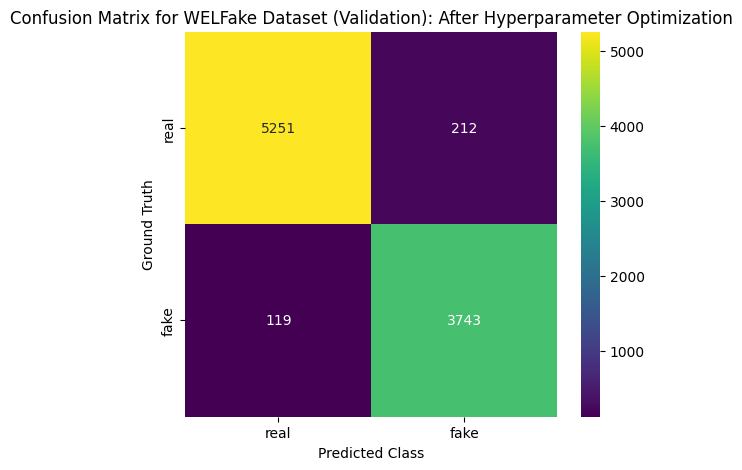

Accuracy: 0.9652
Precision (Macro): 0.9606
Recall (Macro): 0.9663
Macro F1-score: 0.9633

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6976
           1       0.94      0.97      0.95      4261

    accuracy                           0.97     11237
   macro avg       0.96      0.97      0.96     11237
weighted avg       0.97      0.97      0.97     11237



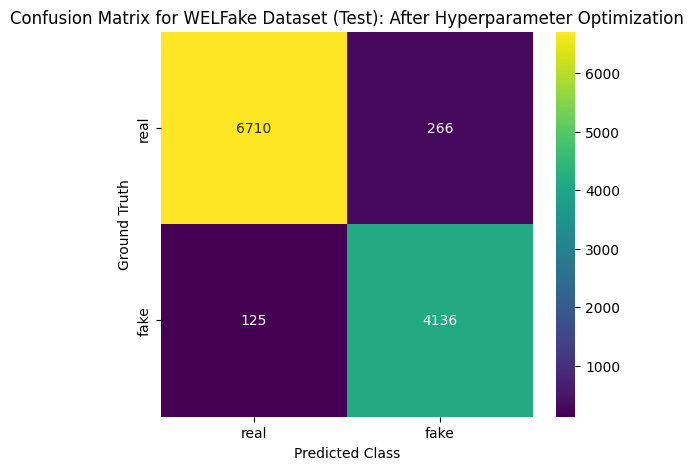

In [27]:
# Trains the model with optimal hyperparameters for WELFake training set and evaluate on WELFake validation set
wf_model = trainModel(
    wf_train_basic_feature_df, # WELfake training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["WELFake", "Best Hyperparameters"]) # Passes in best hyperparams as dict
)

# Evaluates on the validation set
wf_val_eval_dict = evaluateModel(wf_model, wf_val_basic_feature_df, extra_feature_columns, 
                                 "WELFake Dataset (Validation): After Hyperparameter Optimization")
# Evaluates on the test set
wf_test_eval_dict = evaluateModel(wf_model, wf_test_basic_feature_df, extra_feature_columns, 
                                  "WELFake Dataset (Test): After Hyperparameter Optimization")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.9635
Precision (Macro): 0.9618
Recall (Macro): 0.9632
Macro F1-score: 0.9625

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5463
           1       0.95      0.96      0.96      3862

    accuracy                           0.96      9325
   macro avg       0.96      0.96      0.96      9325
weighted avg       0.96      0.96      0.96      9325



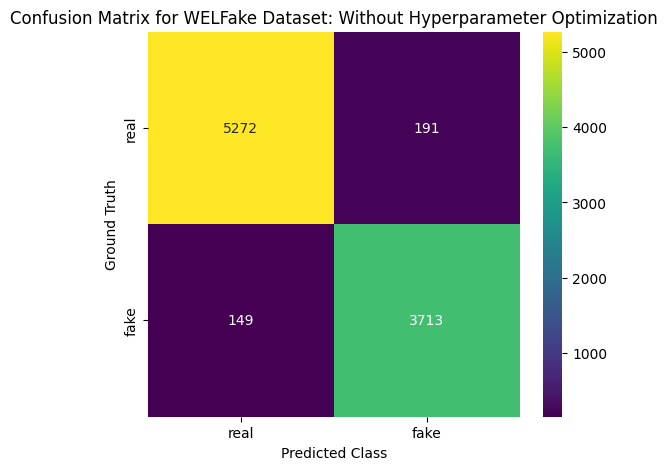

Accuracy: 0.9661
Precision (Macro): 0.9634
Recall (Macro): 0.9647
Macro F1-score: 0.9640

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6976
           1       0.95      0.96      0.96      4261

    accuracy                           0.97     11237
   macro avg       0.96      0.96      0.96     11237
weighted avg       0.97      0.97      0.97     11237



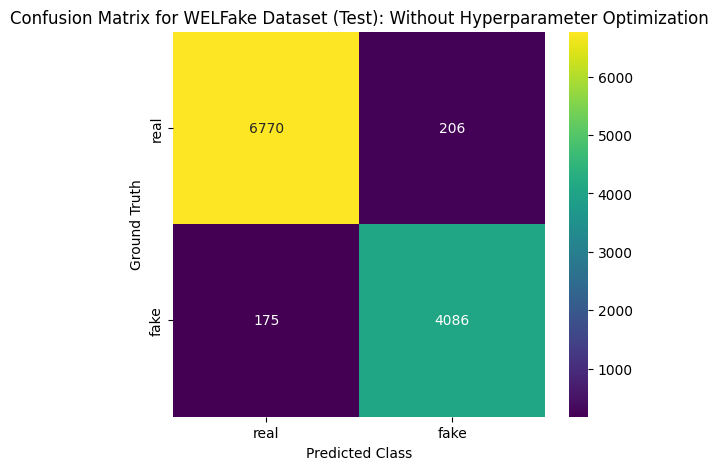

In [67]:
# Trains model withOUT optimal hyperparameters for WELFake training set and evaluate on WELFake validation set
wf_model = trainModelWithoutHyperparameterOptimization(
    wf_train_basic_feature_df, # WELfake training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on validation set
wf_val_eval_dict = evaluateModel(wf_model, wf_val_basic_feature_df, extra_feature_columns, "WELFake Dataset: Without Hyperparameter Optimization")

# Evaluates on test set
wf_test_eval_dict = evaluateModel(wf_model, wf_test_basic_feature_df, extra_feature_columns, 
                                  "WELFake Dataset (Test): Without Hyperparameter Optimization")

Training the model...
Model training complete.
Accuracy: 0.8423
Precision (Macro): 0.8418
Recall (Macro): 0.8375
Macro F1-score: 0.8392

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     39299
           1       0.84      0.80      0.82     31033

    accuracy                           0.84     70332
   macro avg       0.84      0.84      0.84     70332
weighted avg       0.84      0.84      0.84     70332



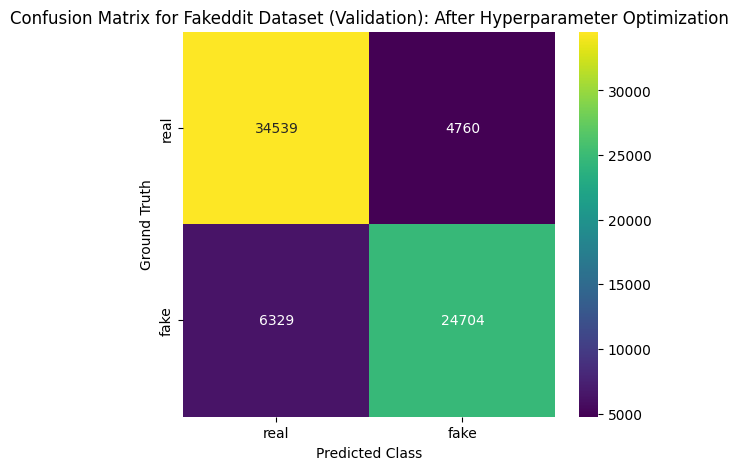

Accuracy: 0.8434
Precision (Macro): 0.8423
Recall (Macro): 0.8387
Macro F1-score: 0.8402

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     39910
           1       0.84      0.80      0.82     31185

    accuracy                           0.84     71095
   macro avg       0.84      0.84      0.84     71095
weighted avg       0.84      0.84      0.84     71095



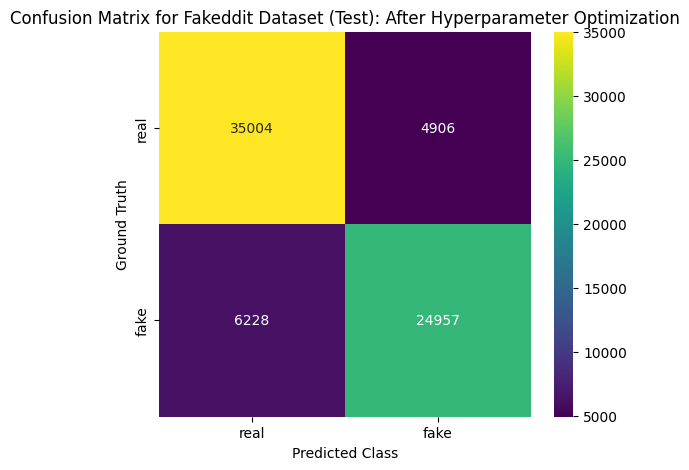

In [39]:
# Trains model with optimal hyperparams for Fakeddit training set
fe_model = trainModel(
    fe_train_basic_feature_df, # Fakeddit training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Fakeddit", "Best Hyperparameters"]) # Pass in best params as dict
)
# Evaluates on validation set
fe_val_dict = evaluateModel(fe_model, fe_val_basic_feature_df, extra_feature_columns,
                            "Fakeddit Dataset (Validation): After Hyperparameter Optimization")

# Evaluates on test set
fe_test_dict = evaluateModel(fe_model, fe_test_basic_feature_df, extra_feature_columns,
                             "Fakeddit Dataset (Test): After Hyperparameter Optimization")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.8630
Precision (Macro): 0.8627
Recall (Macro): 0.8588
Macro F1-score: 0.8604

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     39299
           1       0.86      0.82      0.84     31033

    accuracy                           0.86     70332
   macro avg       0.86      0.86      0.86     70332
weighted avg       0.86      0.86      0.86     70332



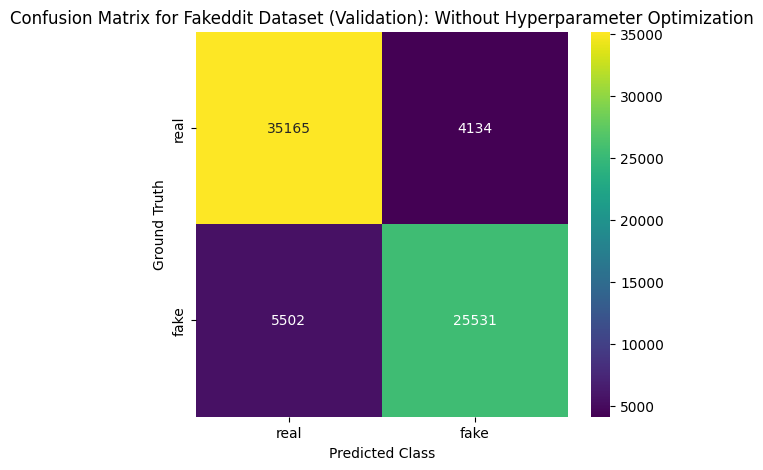

Accuracy: 0.8638
Precision (Macro): 0.8630
Recall (Macro): 0.8597
Macro F1-score: 0.8611

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     39910
           1       0.86      0.83      0.84     31185

    accuracy                           0.86     71095
   macro avg       0.86      0.86      0.86     71095
weighted avg       0.86      0.86      0.86     71095



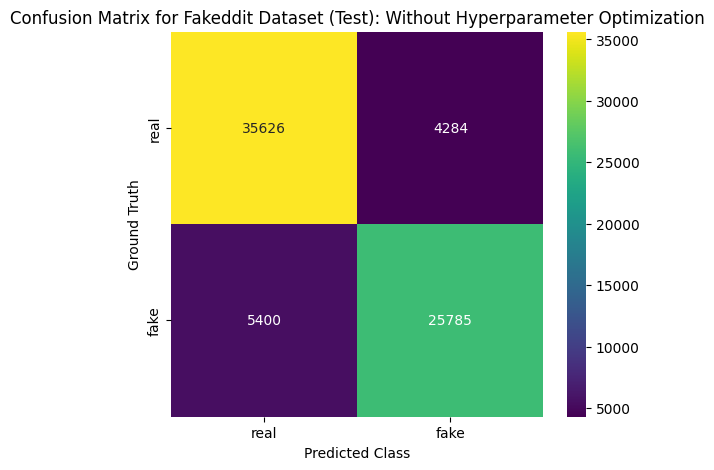

In [40]:
# Trains model withOUT optimal hyperparameters for Fakeddit training set
fe_model = trainModelWithoutHyperparameterOptimization(
    fe_train_basic_feature_df, # Fakeddit training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on validation set
fe_val_dict = evaluateModel(fe_model, fe_val_basic_feature_df, extra_feature_columns, 
                            "Fakeddit Dataset (Validation): Without Hyperparameter Optimization"
                           )

# Evaluates on test set
fe_test_dict = evaluateModel(fe_model, fe_test_basic_feature_df, extra_feature_columns, 
                             "Fakeddit Dataset (Test): Without Hyperparameter Optimization"
                            )

Training the model...
Model training complete.
Accuracy: 0.9474
Precision (Macro): 0.9479
Recall (Macro): 0.9467
Macro F1-score: 0.9472

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1116
           1       0.96      0.93      0.94      1012

    accuracy                           0.95      2128
   macro avg       0.95      0.95      0.95      2128
weighted avg       0.95      0.95      0.95      2128



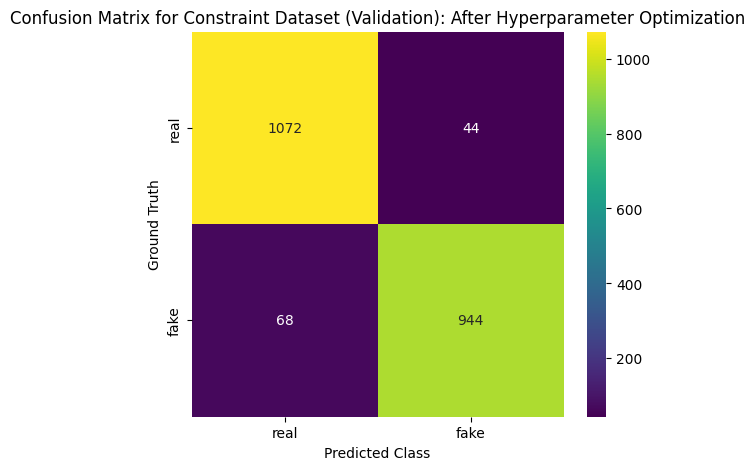

Accuracy: 0.9467
Precision (Macro): 0.9469
Recall (Macro): 0.9463
Macro F1-score: 0.9466

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1115
           1       0.95      0.94      0.94      1007

    accuracy                           0.95      2122
   macro avg       0.95      0.95      0.95      2122
weighted avg       0.95      0.95      0.95      2122



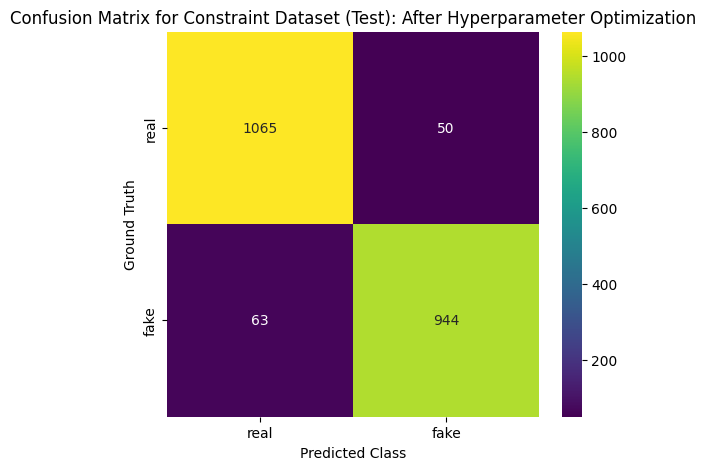

In [68]:
# Trains model with optimal hyperparams for Constraint training set
ct_model = trainModel(
    ct_train_basic_feature_df, # Constraint training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Constraint", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on validation set
ct_val_dict = evaluateModel(ct_model, ct_val_basic_feature_df, extra_feature_columns, 
                            "Constraint Dataset (Validation): After Hyperparameter Optimization"
                           )

# Evaluates on test set
ct_test_dict = evaluateModel(ct_model, ct_test_basic_feature_df, extra_feature_columns, 
                            "Constraint Dataset (Test): After Hyperparameter Optimization"
                           )

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.9295
Precision (Macro): 0.9342
Recall (Macro): 0.9272
Macro F1-score: 0.9289

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1116
           1       0.97      0.88      0.92      1012

    accuracy                           0.93      2128
   macro avg       0.93      0.93      0.93      2128
weighted avg       0.93      0.93      0.93      2128



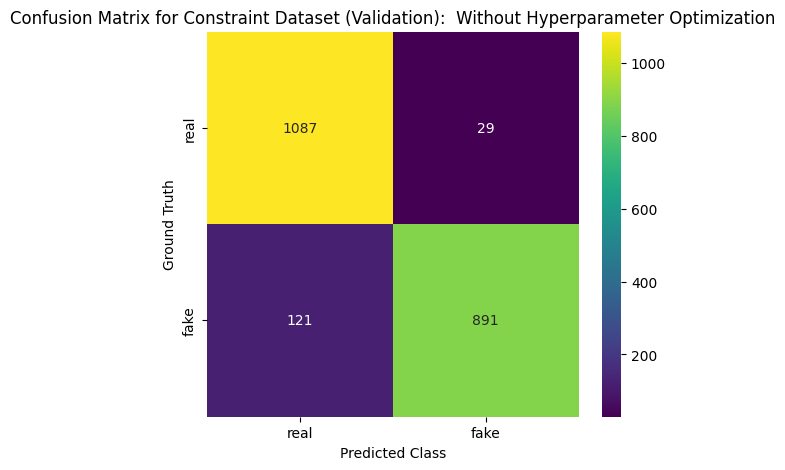

Accuracy: 0.9340
Precision (Macro): 0.9375
Recall (Macro): 0.9320
Macro F1-score: 0.9335

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1115
           1       0.97      0.89      0.93      1007

    accuracy                           0.93      2122
   macro avg       0.94      0.93      0.93      2122
weighted avg       0.94      0.93      0.93      2122



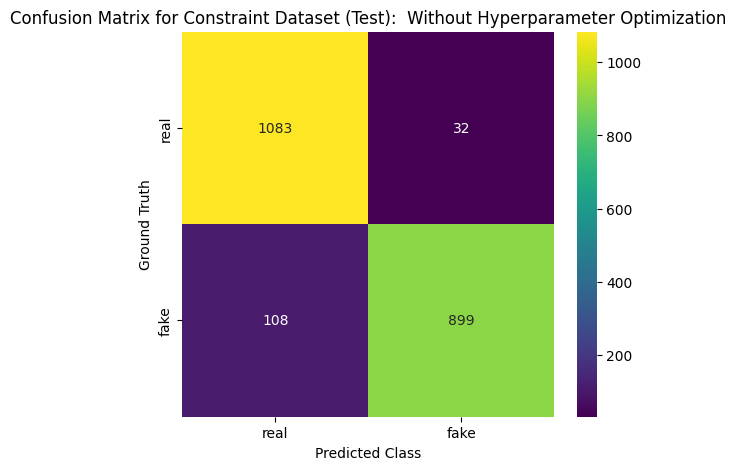

In [45]:
# Trains model withOUT optimal hyperparams for Constraint training set
ct_model = trainModelWithoutHyperparameterOptimization(
    ct_train_basic_feature_df, # Constraint training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on validation set
ct_val_dict = evaluateModel(ct_model, ct_val_basic_feature_df, extra_feature_columns, 
                            "Constraint Dataset (Validation):  Without Hyperparameter Optimization"
                           )

# Evaluates on test set
ct_test_dict = evaluateModel(ct_model, ct_test_basic_feature_df, extra_feature_columns, 
                            "Constraint Dataset (Test):  Without Hyperparameter Optimization"
                           )

Training the model...
Model training complete.
Accuracy: 0.8846
Precision (Macro): 0.8861
Recall (Macro): 0.8930
Macro F1-score: 0.8842

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        59
           1       0.81      0.96      0.88        45

    accuracy                           0.88       104
   macro avg       0.89      0.89      0.88       104
weighted avg       0.90      0.88      0.89       104



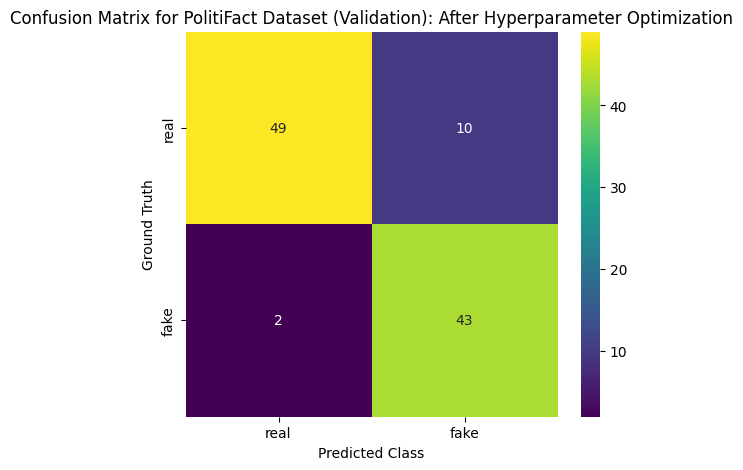

Accuracy: 0.8413
Precision (Macro): 0.8459
Recall (Macro): 0.8431
Macro F1-score: 0.8411

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        61
           1       0.89      0.78      0.84        65

    accuracy                           0.84       126
   macro avg       0.85      0.84      0.84       126
weighted avg       0.85      0.84      0.84       126



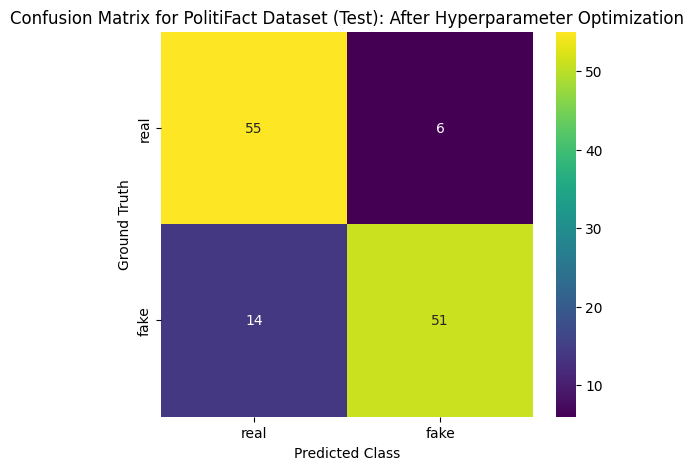

In [44]:
# Trains model with optimal hyperparams for PolitiFact training set
pf_model = trainModel(
    pf_train_basic_feature_df, # PolitiFact training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["PolitiFact", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on validation set
pf_val_dict = evaluateModel(pf_model, pf_val_basic_feature_df, extra_feature_columns, 
                             "PolitiFact Dataset (Validation): After Hyperparameter Optimization"
                            )

# Evaluates on test set
pf_test_dict = evaluateModel(pf_model, pf_test_basic_feature_df, extra_feature_columns, 
                             "PolitiFact Dataset (Test): After Hyperparameter Optimization"
                            )

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.8654
Precision (Macro): 0.8642
Recall (Macro): 0.8708
Macro F1-score: 0.8646

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.83      0.88        59
           1       0.80      0.91      0.85        45

    accuracy                           0.87       104
   macro avg       0.86      0.87      0.86       104
weighted avg       0.87      0.87      0.87       104



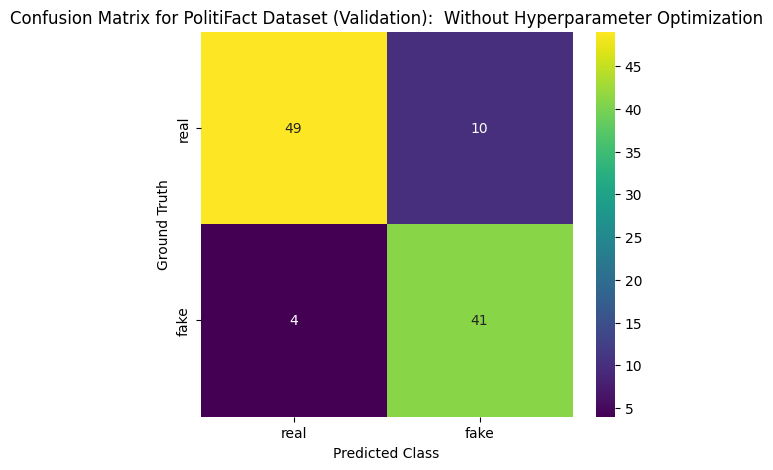

Accuracy: 0.8651
Precision (Macro): 0.8667
Recall (Macro): 0.8662
Macro F1-score: 0.8651

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.87        61
           1       0.90      0.83      0.86        65

    accuracy                           0.87       126
   macro avg       0.87      0.87      0.87       126
weighted avg       0.87      0.87      0.87       126



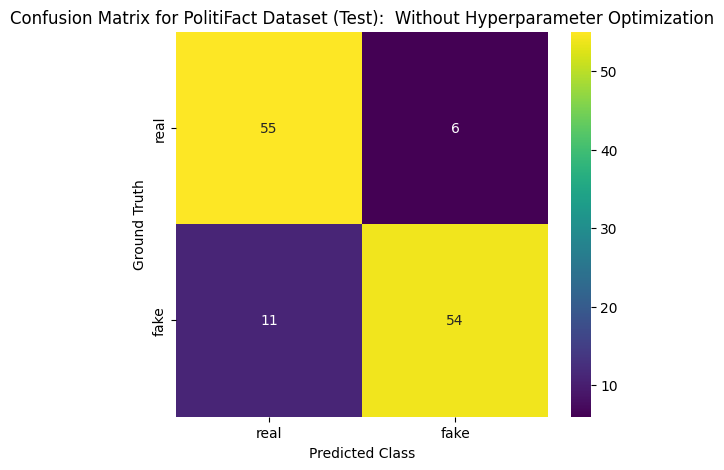

In [46]:
# Trains model withOUT optimal hyperparams for PolitiFact training set
pf_model = trainModelWithoutHyperparameterOptimization(
    pf_train_basic_feature_df, # PolitiFact training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on validation set
pf_val_dict = evaluateModel(pf_model, pf_val_basic_feature_df, extra_feature_columns, 
                            "PolitiFact Dataset (Validation):  Without Hyperparameter Optimization"
                           )

# Evaluates on test set
pf_test_dict = evaluateModel(pf_model, pf_test_basic_feature_df, extra_feature_columns, 
                            "PolitiFact Dataset (Test):  Without Hyperparameter Optimization"
                           )

Training the model...
Model training complete.
Accuracy: 0.8510
Precision (Macro): 0.8052
Recall (Macro): 0.7509
Macro F1-score: 0.7719

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2018
           1       0.73      0.56      0.64       612

    accuracy                           0.85      2630
   macro avg       0.81      0.75      0.77      2630
weighted avg       0.84      0.85      0.84      2630



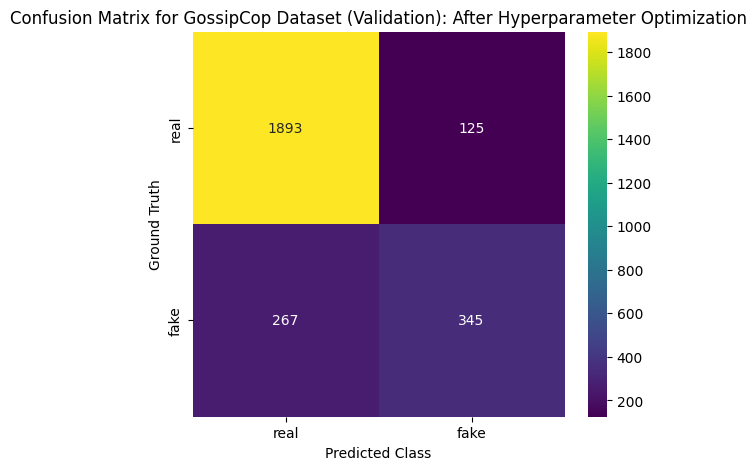

Accuracy: 0.8403
Precision (Macro): 0.7872
Recall (Macro): 0.7440
Macro F1-score: 0.7613

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2444
           1       0.70      0.56      0.62       755

    accuracy                           0.84      3199
   macro avg       0.79      0.74      0.76      3199
weighted avg       0.83      0.84      0.83      3199



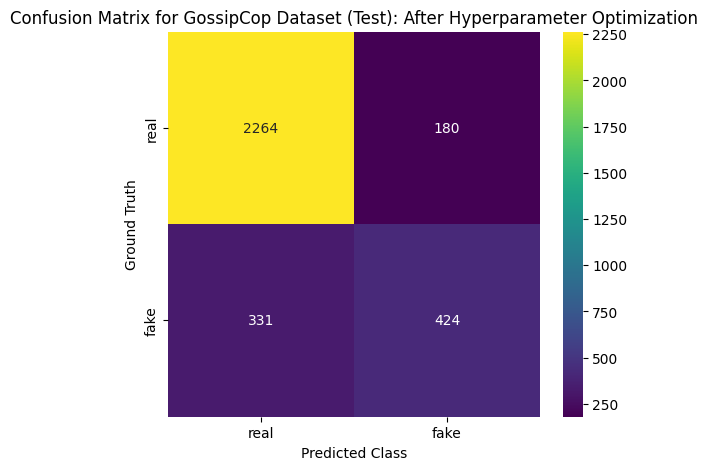

In [47]:
# Trains model with optimal hyperparams for GossipCop training set
gc_model = trainModel(
    gc_train_basic_feature_df, # GossipCop training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["GossipCop", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on validation set
gc_val_dict = evaluateModel(gc_model, gc_val_basic_feature_df, extra_feature_columns,
                             "GossipCop Dataset (Validation): After Hyperparameter Optimization"
                            )

# Evaluates on test set
gc_test_dict = evaluateModel(gc_model, gc_test_basic_feature_df, extra_feature_columns,
                             "GossipCop Dataset (Test): After Hyperparameter Optimization"
                            )

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.8616
Precision (Macro): 0.8404
Recall (Macro): 0.7459
Macro F1-score: 0.7773

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2018
           1       0.81      0.53      0.64       612

    accuracy                           0.86      2630
   macro avg       0.84      0.75      0.78      2630
weighted avg       0.86      0.86      0.85      2630



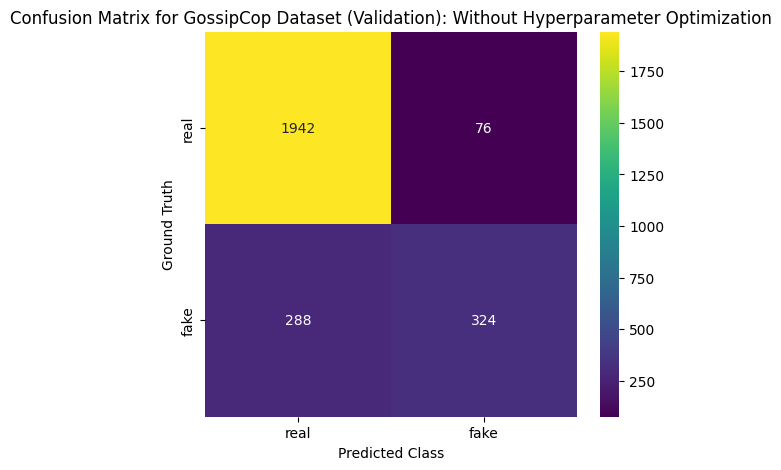

Accuracy: 0.8540
Precision (Macro): 0.8226
Recall (Macro): 0.7443
Macro F1-score: 0.7716

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2444
           1       0.78      0.54      0.63       755

    accuracy                           0.85      3199
   macro avg       0.82      0.74      0.77      3199
weighted avg       0.85      0.85      0.84      3199



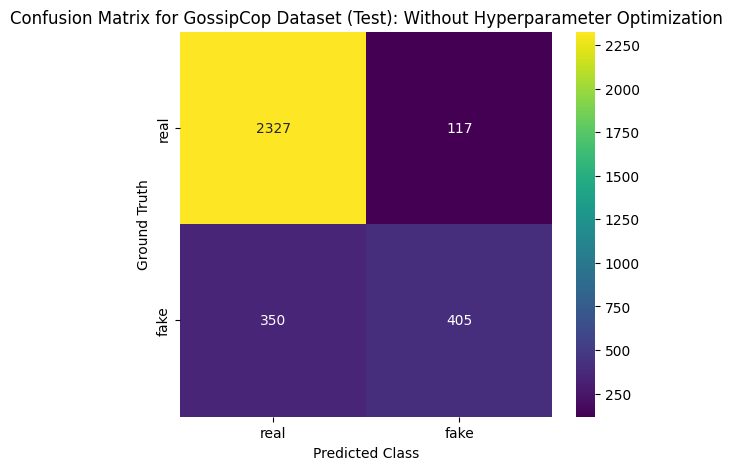

In [48]:
# Trains model model withOUT optimal hyperparams for GossipCop training set
gc_model = trainModelWithoutHyperparameterOptimization(
    gc_train_basic_feature_df, # GossipCop training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on validation set
gc_eval_dict = evaluateModel(gc_model, gc_val_basic_feature_df, extra_feature_columns, 
                             "GossipCop Dataset (Validation): Without Hyperparameter Optimization"
                            )
# Evaluates on test set
gc_test_dict = evaluateModel(gc_model, gc_test_basic_feature_df, extra_feature_columns, 
                             "GossipCop Dataset (Test): Without Hyperparameter Optimization"
                            )

## Training on all 4 Text-Based Datasets (WELFake, Constraint, PolitiFact, GossipCop) from Different Domains and Evaluating on the Same 4 Datasets' Validation Splits, Concatenated

In [72]:
all_four_datasets_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/all_four_datasets_train_basic_features.csv")
all_four_datasets_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/all_four_datasets_val_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.8998
Precision (Macro): 0.8937
Recall (Macro): 0.8968
Macro F1-score: 0.8951

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      8656
           1       0.86      0.88      0.87      5531

    accuracy                           0.90     14187
   macro avg       0.89      0.90      0.90     14187
weighted avg       0.90      0.90      0.90     14187



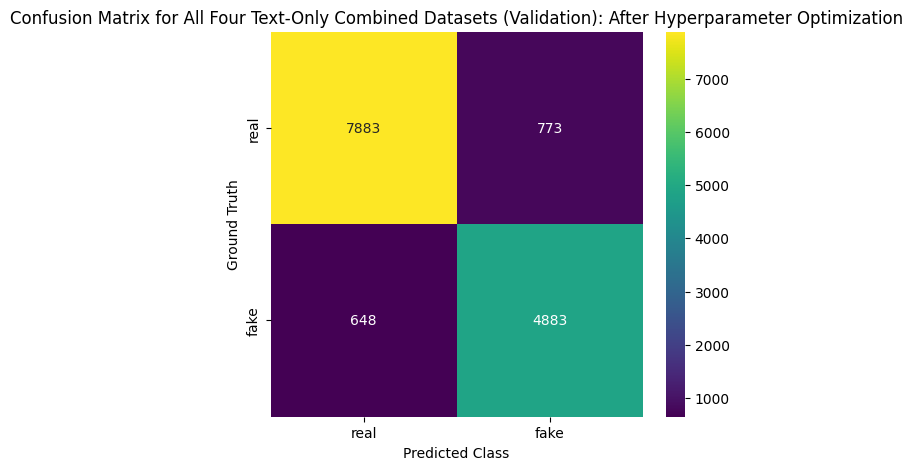

Accuracy: 0.9007
Precision (Macro): 0.8913
Recall (Macro): 0.8960
Macro F1-score: 0.8935

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10596
           1       0.85      0.88      0.87      6087

    accuracy                           0.90     16683
   macro avg       0.89      0.90      0.89     16683
weighted avg       0.90      0.90      0.90     16683



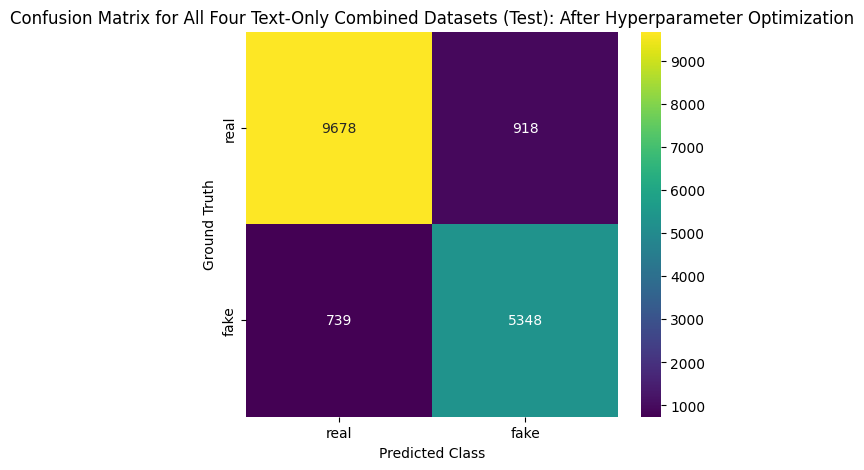

In [50]:
# Trains model with optimal hyperparams for all four only text datasets combined
all_four_model = trainModel(
    all_four_datasets_train_basic_feature_df, # All four combined training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["All_Four_Combined", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on all-combined validation set
all_four_val_dict = evaluateModel(all_four_model,
                                   all_four_datasets_val_basic_feature_df,
                                   extra_feature_columns,
                                   "All Four Text-Only Combined Datasets (Validation): After Hyperparameter Optimization")

# Evaluates on all-combined test set
all_four_test_dict = evaluateModel(all_four_model,
                                   all_four_datasets_test_basic_feature_df,
                                   extra_feature_columns,
                                   "All Four Text-Only Combined Datasets (Test): After Hyperparameter Optimization")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.9254
Precision (Macro): 0.9237
Recall (Macro): 0.9188
Macro F1-score: 0.9211

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8656
           1       0.92      0.89      0.90      5531

    accuracy                           0.93     14187
   macro avg       0.92      0.92      0.92     14187
weighted avg       0.93      0.93      0.93     14187



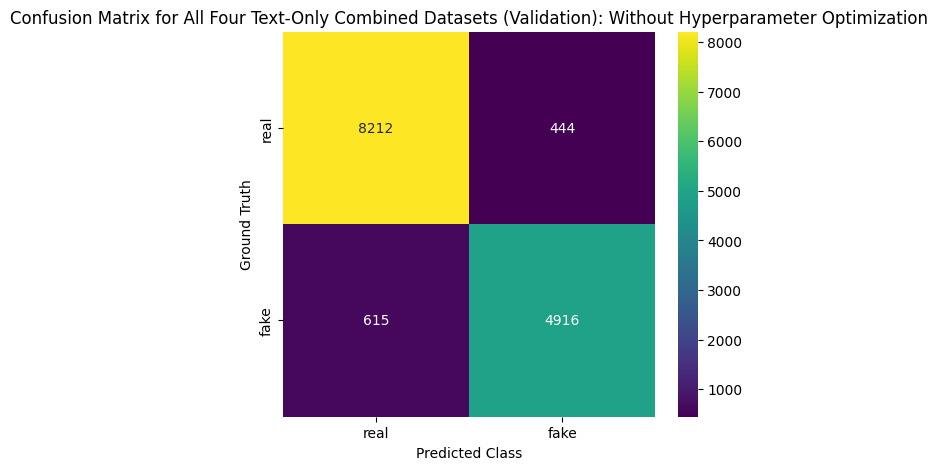

Accuracy: 0.9267
Precision (Macro): 0.9233
Recall (Macro): 0.9178
Macro F1-score: 0.9204

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10596
           1       0.91      0.88      0.90      6087

    accuracy                           0.93     16683
   macro avg       0.92      0.92      0.92     16683
weighted avg       0.93      0.93      0.93     16683



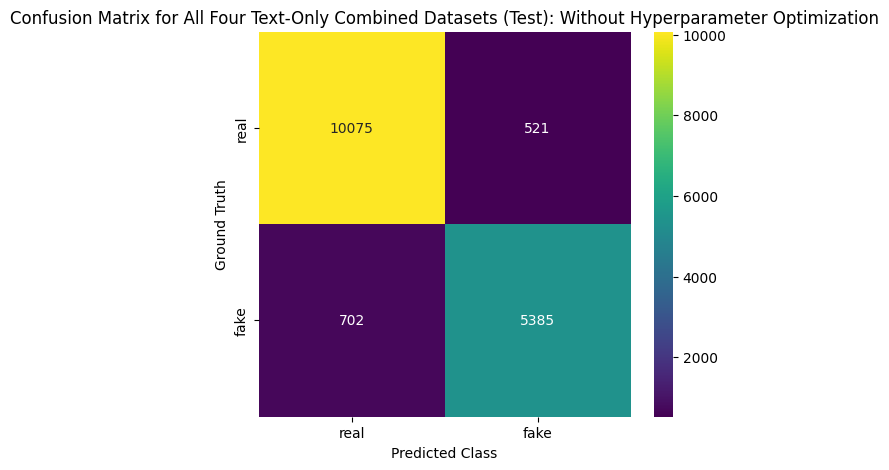

In [51]:
# Trains model withOUT optimal hyperparams for all four only text datasets combined
all_four_model = trainModelWithoutHyperparameterOptimization(
    all_four_datasets_train_basic_feature_df, # All four combined training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on all-combined validation set
all_four_eval_dict = evaluateModel(all_four_model,
                                   all_four_datasets_val_basic_feature_df,
                                   extra_feature_columns,
                                   "All Four Text-Only Combined Datasets (Validation): Without Hyperparameter Optimization")

# Evaluates on all-combined test set
all_four_test_dict = evaluateModel(all_four_model,
                                   all_four_datasets_test_basic_feature_df,
                                   extra_feature_columns,
                                   "All Four Text-Only Combined Datasets (Test): Without Hyperparameter Optimization")

This model is the one which will be used for user testing LIME-based explanations in the Streamlit applications, as it draws on a combination of all the long-form (therefore NOT Fakeddit) datasets and receives a reasonably high macro-average F1-score on all those four datasets' validation splits.

### Five-Shot Scenario Evaluation (3 Source Combined Datasets for Training + 5 Random Samples from Target Dataset, Evaluation on Validation Set from Left-Out Dataset)

In [54]:
wf_target_five_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Five_Shot_WELFake_Target_basic_features.csv")
wf_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/WELFake_val_basic_features.csv")
wf_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/WELFake_test_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.6109
Precision (Macro): 0.5962
Recall (Macro): 0.5938
Macro F1-score: 0.5944

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.69      0.68      5463
           1       0.53      0.49      0.51      3862

    accuracy                           0.61      9325
   macro avg       0.60      0.59      0.59      9325
weighted avg       0.61      0.61      0.61      9325



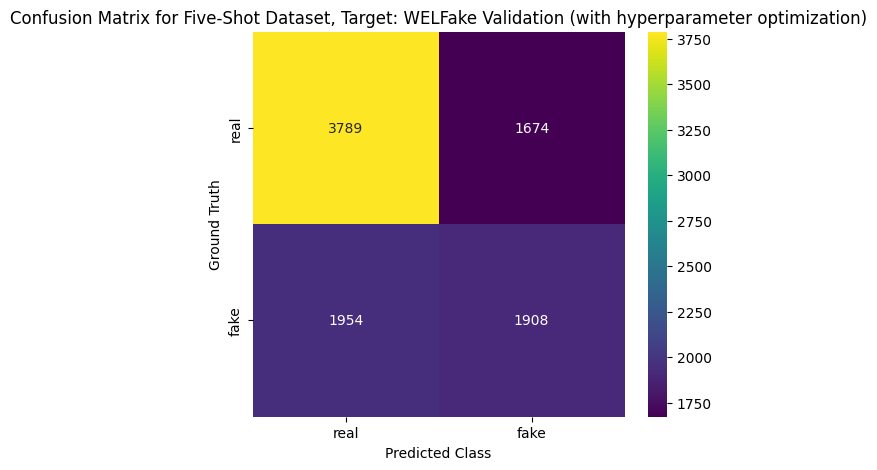

Accuracy: 0.6298
Precision (Macro): 0.6068
Recall (Macro): 0.6068
Macro F1-score: 0.6068

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      6976
           1       0.51      0.51      0.51      4261

    accuracy                           0.63     11237
   macro avg       0.61      0.61      0.61     11237
weighted avg       0.63      0.63      0.63     11237



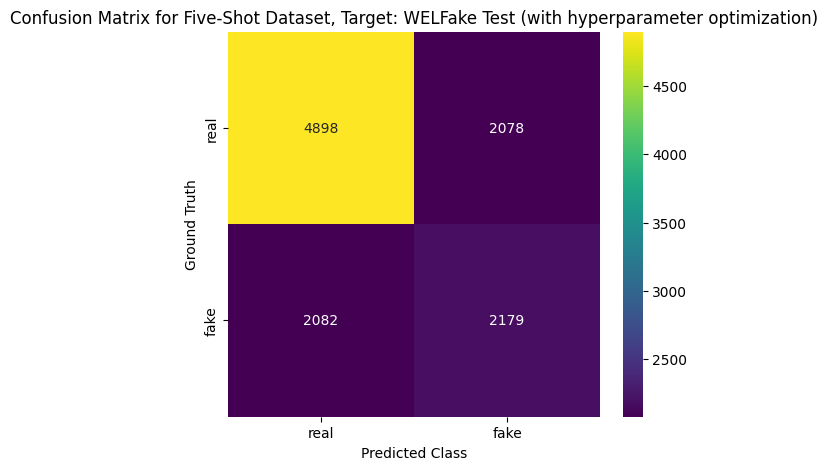

In [55]:
# Trains model with optimal hyperparams on five-shot mixed dataset with WELFake contributing only 5 samples
five_shot_target_wf_model = trainModel(
    wf_target_five_shot_train_basic_feature_df, # WELFake target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Five_Shot_WELFake_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on WELFake target validation set
five_shot_target_wf_val_dict = evaluateModel(five_shot_target_wf_model, wf_val_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: WELFake Validation (with hyperparameter optimization)")

# Evaluates on WELFake target test set
five_shot_target_wf_test_dict = evaluateModel(five_shot_target_wf_model, wf_test_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: WELFake Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.6257
Precision (Macro): 0.6098
Recall (Macro): 0.5872
Macro F1-score: 0.5815

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.81      0.72      5463
           1       0.58      0.36      0.45      3862

    accuracy                           0.63      9325
   macro avg       0.61      0.59      0.58      9325
weighted avg       0.62      0.63      0.60      9325



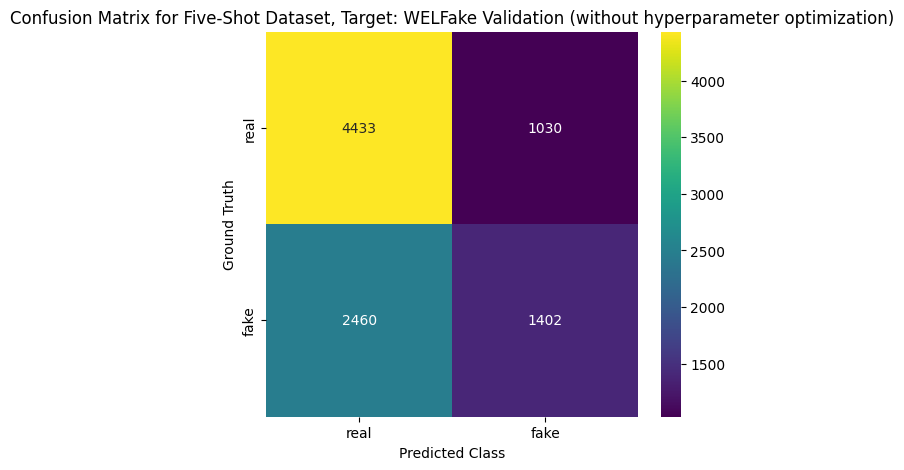

Accuracy: 0.6463
Precision (Macro): 0.6148
Recall (Macro): 0.5949
Macro F1-score: 0.5948

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      6976
           1       0.55      0.38      0.45      4261

    accuracy                           0.65     11237
   macro avg       0.61      0.59      0.59     11237
weighted avg       0.63      0.65      0.63     11237



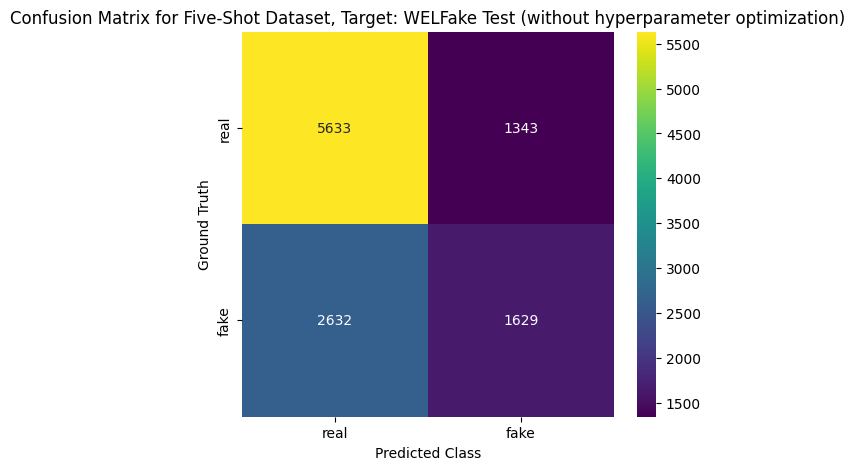

In [57]:
# Trains model withOUT optimal hyperparams on five-shot mixed dataset with WELFake contributing only 5 samples
five_shot_target_wf_model = trainModelWithoutHyperparameterOptimization(
    wf_target_five_shot_train_basic_feature_df, # WELFake target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on Constraint target validation set
five_shot_target_wf_eval_dict = evaluateModel(five_shot_target_wf_model, wf_val_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: WELFake Validation (without hyperparameter optimization)")

# Evaluates on Constraint target test set
five_shot_target_wf_test_dict = evaluateModel(five_shot_target_wf_model, wf_test_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: WELFake Test (without hyperparameter optimization)")

In [58]:
ct_target_five_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Five_Shot_Constraint_Target_basic_features.csv")
ct_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Constraint_val_basic_features.csv")
ct_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Constraint_test_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.4840
Precision (Macro): 0.4969
Recall (Macro): 0.4979
Macro F1-score: 0.4468

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.21      0.30      1116
           1       0.47      0.78      0.59      1012

    accuracy                           0.48      2128
   macro avg       0.50      0.50      0.45      2128
weighted avg       0.50      0.48      0.44      2128



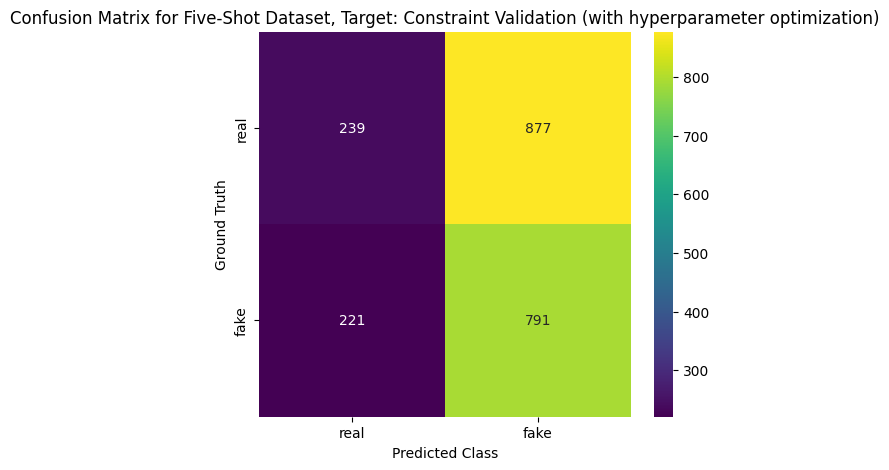

Accuracy: 0.4826
Precision (Macro): 0.4949
Recall (Macro): 0.4964
Macro F1-score: 0.4490

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.22      0.31      1115
           1       0.47      0.77      0.59      1007

    accuracy                           0.48      2122
   macro avg       0.49      0.50      0.45      2122
weighted avg       0.50      0.48      0.44      2122



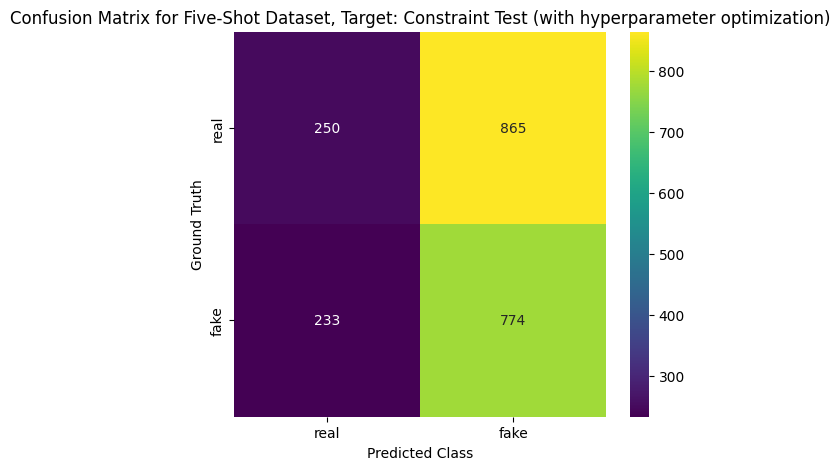

In [59]:
# Trains model with optimal hyperparams on five-shot mixed dataset with Constraint contributing only 5 samples
five_shot_target_ct_model = trainModel(
    ct_target_five_shot_train_basic_feature_df, # Constraint target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Five_Shot_Constraint_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on Constraint target validation set
five_shot_target_ct_eval_dict = evaluateModel(five_shot_target_ct_model, ct_val_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: Constraint Validation (with hyperparameter optimization)")
# Evaluates on Constraint target test set
five_shot_target_ct_test_dict = evaluateModel(five_shot_target_ct_model, ct_test_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: Constraint Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.4601
Precision (Macro): 0.4543
Recall (Macro): 0.4774
Macro F1-score: 0.3935

Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.12      0.19      1116
           1       0.46      0.83      0.59      1012

    accuracy                           0.46      2128
   macro avg       0.45      0.48      0.39      2128
weighted avg       0.45      0.46      0.38      2128



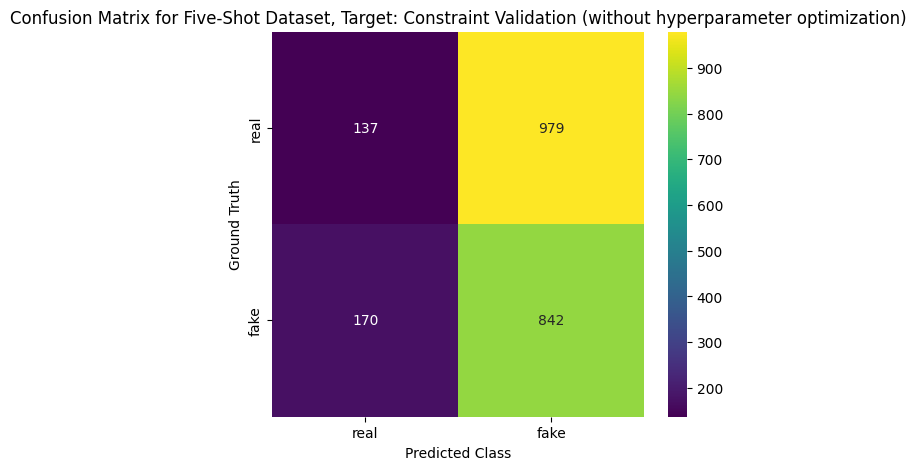

Accuracy: 0.4670
Precision (Macro): 0.4701
Recall (Macro): 0.4849
Macro F1-score: 0.4034

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.13      0.21      1115
           1       0.47      0.84      0.60      1007

    accuracy                           0.47      2122
   macro avg       0.47      0.48      0.40      2122
weighted avg       0.47      0.47      0.39      2122



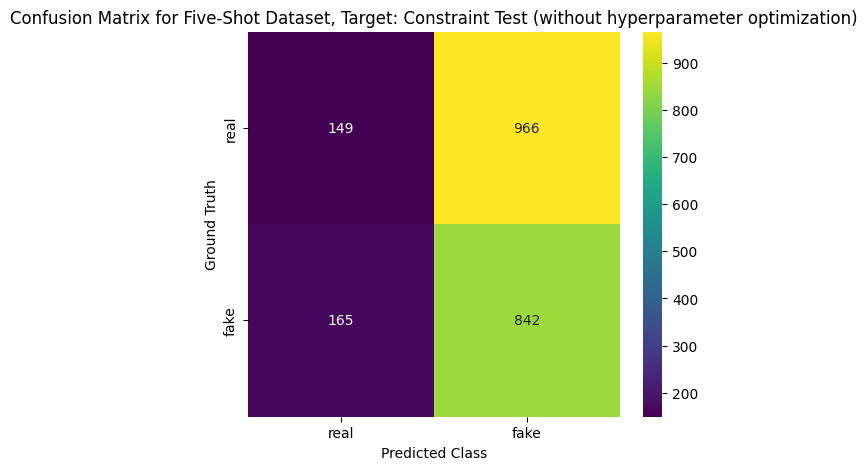

In [60]:
# Trains model withOUT optimal hyperparams on five-shot mixed dataset with Constraint contributing only 5 samples
five_shot_target_ct_model = trainModelWithoutHyperparameterOptimization(
    ct_target_five_shot_train_basic_feature_df, # Constraint target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on Constraint target validation set
five_shot_target_ct_val_dict = evaluateModel(five_shot_target_ct_model, ct_val_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: Constraint Validation (without hyperparameter optimization)")
# Evaluates on Constraint target test set
five_shot_target_ct_test_dict = evaluateModel(five_shot_target_ct_model, ct_test_basic_feature_df, extra_feature_columns,
                                             "Five-Shot Dataset, Target: Constraint Test (without hyperparameter optimization)")

In [61]:
pf_target_five_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Five_Shot_PolitiFact_Target_basic_features.csv")
pf_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/PolitiFact_val_basic_features.csv")
pf_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/PolitiFact_test_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.6635
Precision (Macro): 0.6735
Recall (Macro): 0.6744
Macro F1-score: 0.6634

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.59      0.67        59
           1       0.59      0.76      0.66        45

    accuracy                           0.66       104
   macro avg       0.67      0.67      0.66       104
weighted avg       0.69      0.66      0.66       104



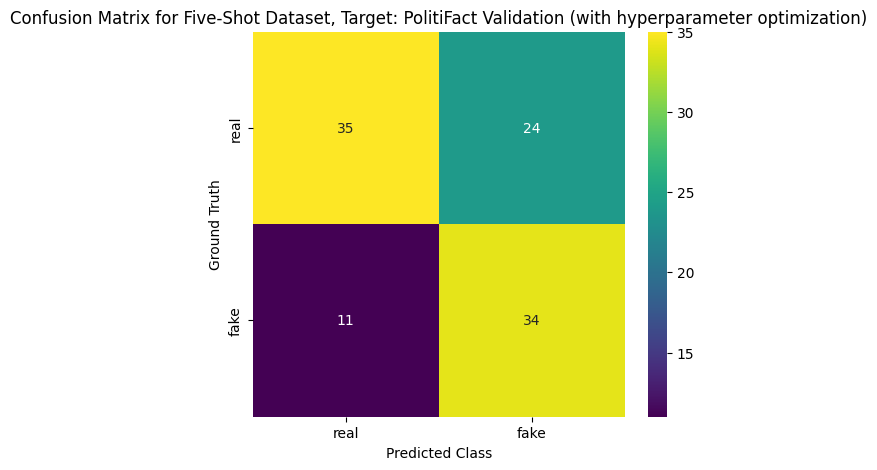

Accuracy: 0.6032
Precision (Macro): 0.6033
Recall (Macro): 0.6008
Macro F1-score: 0.5995

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.52      0.56        61
           1       0.60      0.68      0.64        65

    accuracy                           0.60       126
   macro avg       0.60      0.60      0.60       126
weighted avg       0.60      0.60      0.60       126



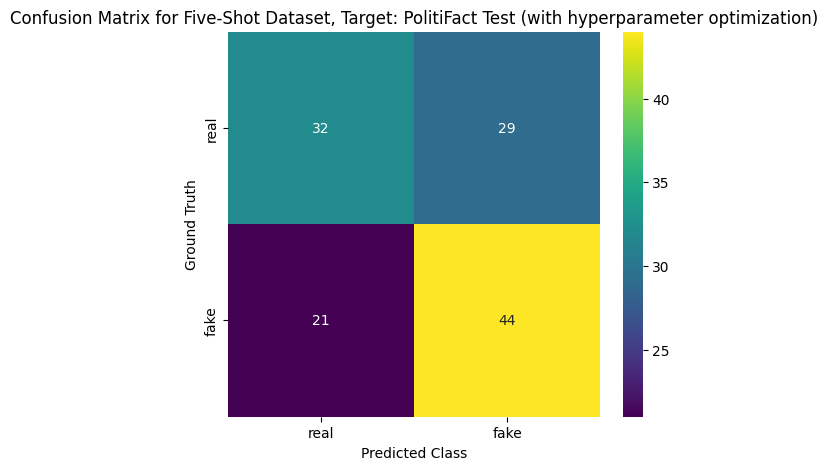

In [62]:
# Trains model with optimal hyperparams on five-shot mixed dataset with PolitiFact contributing only 5 samples
five_shot_target_pf_model = trainModel(
    pf_target_five_shot_train_basic_feature_df, # PolitiFact target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Five_Shot_PolitiFact_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on PolitiFact target validation set
five_shot_target_pf_val_dict = evaluateModel(five_shot_target_pf_model, pf_val_basic_feature_df, extra_feature_columns,
                                            "Five-Shot Dataset, Target: PolitiFact Validation (with hyperparameter optimization)")
# Evaluates on PolitiFact target test set
five_shot_target_pf_test_dict = evaluateModel(five_shot_target_pf_model, pf_test_basic_feature_df, extra_feature_columns,
                                            "Five-Shot Dataset, Target: PolitiFact Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.6635
Precision (Macro): 0.6696
Recall (Macro): 0.6718
Macro F1-score: 0.6632

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.61      0.67        59
           1       0.59      0.73      0.65        45

    accuracy                           0.66       104
   macro avg       0.67      0.67      0.66       104
weighted avg       0.68      0.66      0.66       104



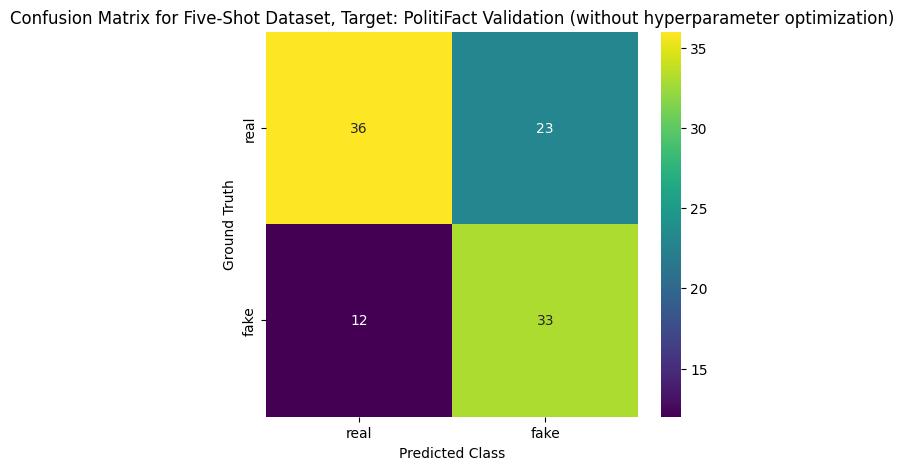

Accuracy: 0.5952
Precision (Macro): 0.5995
Recall (Macro): 0.5905
Macro F1-score: 0.5837

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.44      0.51        61
           1       0.59      0.74      0.65        65

    accuracy                           0.60       126
   macro avg       0.60      0.59      0.58       126
weighted avg       0.60      0.60      0.59       126



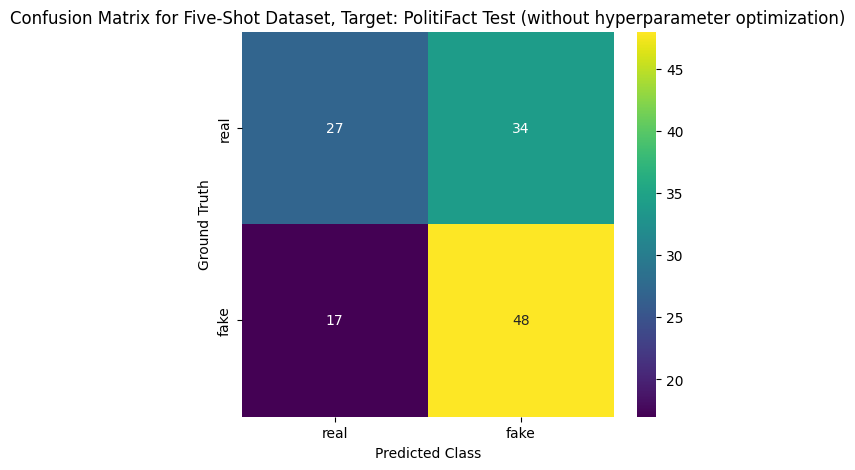

In [63]:
# Trains model withOUT optimal hyperparams on five-shot mixed dataset with PolitiFact contributing only 5 samples
five_shot_target_pf_model = trainModelWithoutHyperparameterOptimization(
    pf_target_five_shot_train_basic_feature_df, # PolitiFact target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on GossipCop target validation set
five_shot_target_pf_val_dict = evaluateModel(five_shot_target_pf_model, pf_val_basic_feature_df, extra_feature_columns,
                                            "Five-Shot Dataset, Target: PolitiFact Validation (without hyperparameter optimization)")

# Evaluates on GossipCop target test set
five_shot_target_pf_test_dict = evaluateModel(five_shot_target_pf_model, pf_test_basic_feature_df, extra_feature_columns,
                                            "Five-Shot Dataset, Target: PolitiFact Test (without hyperparameter optimization)")

In [64]:
gc_target_five_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Five_Shot_GossipCop_Target_basic_features.csv")
gc_val_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/GossipCop_val_basic_features.csv")
gc_test_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/GossipCop_test_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.3943
Precision (Macro): 0.5595
Recall (Macro): 0.5581
Macro F1-score: 0.3943

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.25      0.39      2018
           1       0.26      0.86      0.40       612

    accuracy                           0.39      2630
   macro avg       0.56      0.56      0.39      2630
weighted avg       0.72      0.39      0.39      2630



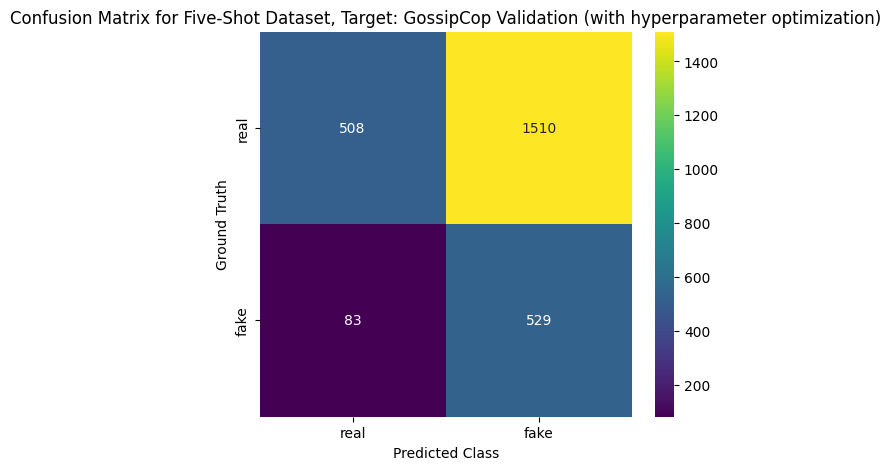

Accuracy: 0.4008
Precision (Macro): 0.5596
Recall (Macro): 0.5588
Macro F1-score: 0.4007

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.26      0.40      2444
           1       0.26      0.86      0.40       755

    accuracy                           0.40      3199
   macro avg       0.56      0.56      0.40      3199
weighted avg       0.72      0.40      0.40      3199



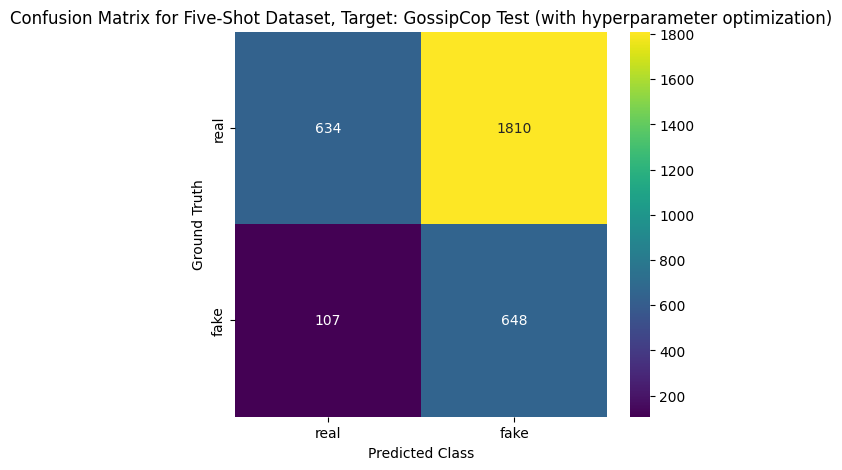

In [65]:
# Trains model with optimal hyperparams on five-shot mixed dataset with GossipCop contributing only 5 samples
five_shot_target_gc_model = trainModel(
    gc_target_five_shot_train_basic_feature_df, # GossipCop target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Five_Shot_GossipCop_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on GossipCop target validation set
five_shot_target_gc_val_dict = evaluateModel(five_shot_target_gc_model, gc_val_basic_feature_df, extra_feature_columns,
                                                "Five-Shot Dataset, Target: GossipCop Validation (with hyperparameter optimization)")

# Evaluates on GossipCop target test set
five_shot_target_gc_test_dict = evaluateModel(five_shot_target_gc_model, gc_test_basic_feature_df, extra_feature_columns,
                                                "Five-Shot Dataset, Target: GossipCop Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.4768
Precision (Macro): 0.5722
Recall (Macro): 0.5902
Macro F1-score: 0.4711

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.38      0.53      2018
           1       0.28      0.80      0.42       612

    accuracy                           0.48      2630
   macro avg       0.57      0.59      0.47      2630
weighted avg       0.73      0.48      0.50      2630



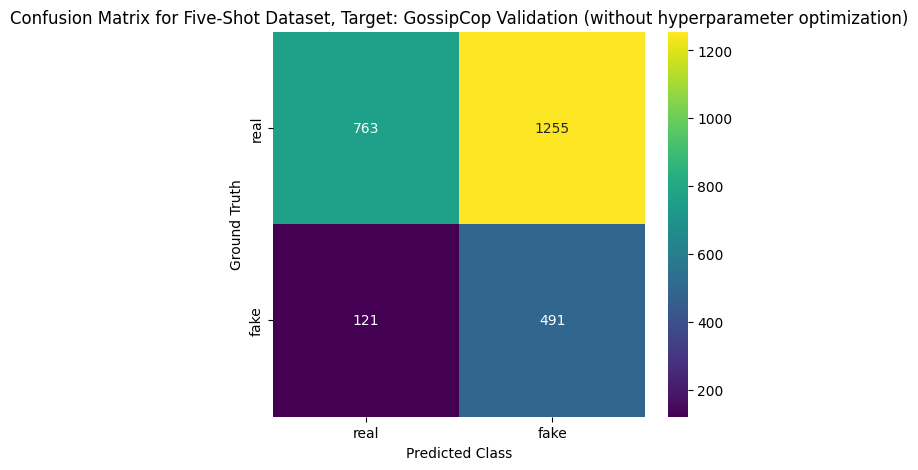

Accuracy: 0.4626
Precision (Macro): 0.5564
Recall (Macro): 0.5696
Macro F1-score: 0.4574

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.37      0.51      2444
           1       0.27      0.77      0.40       755

    accuracy                           0.46      3199
   macro avg       0.56      0.57      0.46      3199
weighted avg       0.71      0.46      0.49      3199



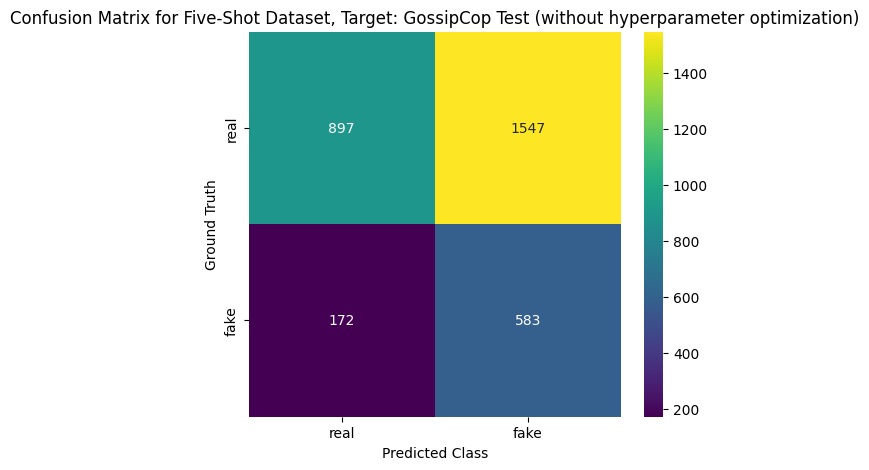

In [66]:
# Trains model withOUT optimal hyperparams on five-shot mixed dataset with GossipCop contributing only 5 samples
five_shot_target_gc_model = trainModelWithoutHyperparameterOptimization(
    gc_target_five_shot_train_basic_feature_df, # GossipCop target five-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on GossipCop target validation set
five_shot_target_gc_val_dict = evaluateModel(five_shot_target_gc_model, gc_val_basic_feature_df, extra_feature_columns,
                                                "Five-Shot Dataset, Target: GossipCop Validation (without hyperparameter optimization)")

# Evaluates on GossipCop target test set
five_shot_target_gc_test_dict = evaluateModel(five_shot_target_gc_model, gc_test_basic_feature_df, extra_feature_columns,
                                                "Five-Shot Dataset, Target: GossipCop Test (without hyperparameter optimization)")

### Zero-Shot Scenario Evaluation (3 Source Combined Datasets for Training, Evaluation on Validation Set from Left-Out Dataset)

In [69]:
wf_target_zero_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Zero_Shot_WELFake_Target_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.6093
Precision (Macro): 0.5940
Recall (Macro): 0.5912
Macro F1-score: 0.5918

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      5463
           1       0.53      0.49      0.51      3862

    accuracy                           0.61      9325
   macro avg       0.59      0.59      0.59      9325
weighted avg       0.60      0.61      0.61      9325



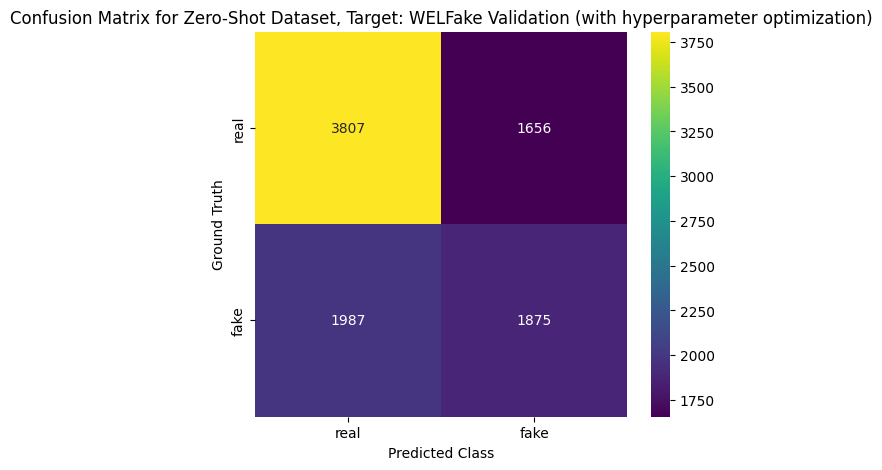

Accuracy: 0.6269
Precision (Macro): 0.6032
Recall (Macro): 0.6028
Macro F1-score: 0.6030

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      6976
           1       0.51      0.50      0.51      4261

    accuracy                           0.63     11237
   macro avg       0.60      0.60      0.60     11237
weighted avg       0.63      0.63      0.63     11237



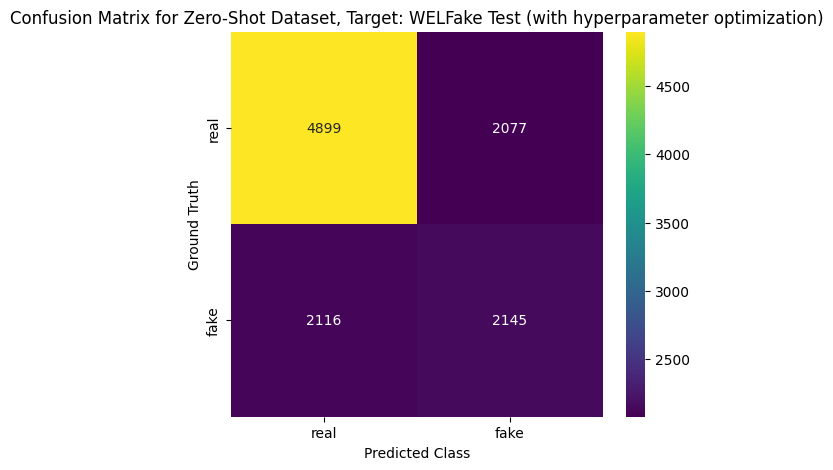

In [72]:
# Trains model with optimal hyperparams on zero-shot mixed dataset with zero WELFake samples
zero_shot_target_wf_model = trainModel(
    wf_target_zero_shot_train_basic_feature_df, # WELFake target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Zero_Shot_WELFake_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on WELFake target validation set
zero_shot_target_wf_val_dict = evaluateModel(zero_shot_target_wf_model, wf_val_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: WELFake Validation (with hyperparameter optimization)")
# Evaluates on WELFake target test set
zero_shot_target_wf_test_dict = evaluateModel(zero_shot_target_wf_model, wf_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: WELFake Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.6222
Precision (Macro): 0.6048
Recall (Macro): 0.5859
Macro F1-score: 0.5814

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.80      0.71      5463
           1       0.57      0.37      0.45      3862

    accuracy                           0.62      9325
   macro avg       0.60      0.59      0.58      9325
weighted avg       0.61      0.62      0.60      9325



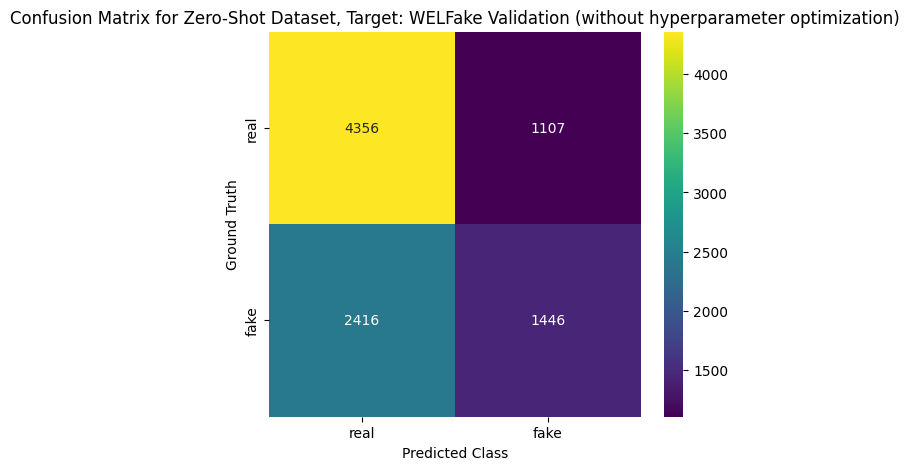

Accuracy: 0.6422
Precision (Macro): 0.6101
Recall (Macro): 0.5935
Macro F1-score: 0.5938

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.80      0.73      6976
           1       0.54      0.39      0.45      4261

    accuracy                           0.64     11237
   macro avg       0.61      0.59      0.59     11237
weighted avg       0.63      0.64      0.63     11237



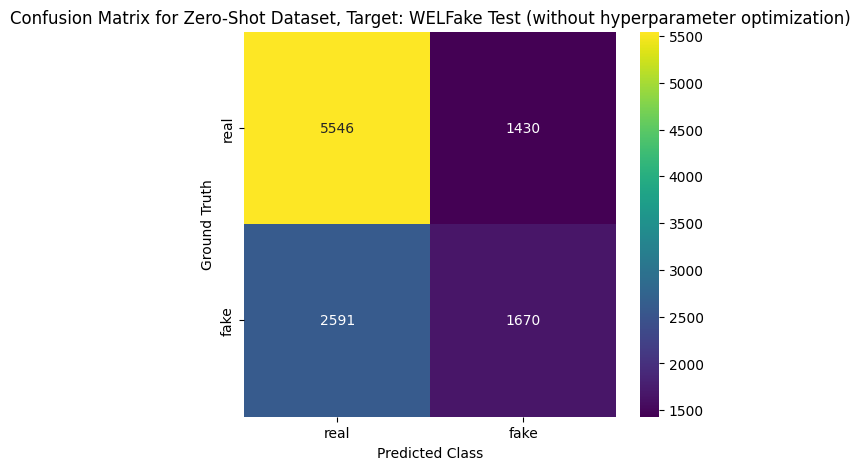

In [84]:
# Trains model withOUT optimal hyperparams on zero-shot mixed dataset with zero WELFake samples
zero_shot_target_wf_model = trainModelWithoutHyperparameterOptimization(
    wf_target_zero_shot_train_basic_feature_df, # WELFake target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on WELFake target validation set
zero_shot_target_wf_val_dict = evaluateModel(zero_shot_target_wf_model, wf_val_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: WELFake Validation (without hyperparameter optimization)")

# Evaluates on WELFake target test set
zero_shot_target_wf_test_dict = evaluateModel(zero_shot_target_wf_model, wf_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: WELFake Test (without hyperparameter optimization)")

In [74]:
ct_target_zero_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Zero_Shot_Constraint_Target_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.4201
Precision (Macro): 0.3957
Recall (Macro): 0.4350
Macro F1-score: 0.3697

Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.13      0.19      1116
           1       0.44      0.74      0.55      1012

    accuracy                           0.42      2128
   macro avg       0.40      0.43      0.37      2128
weighted avg       0.39      0.42      0.36      2128



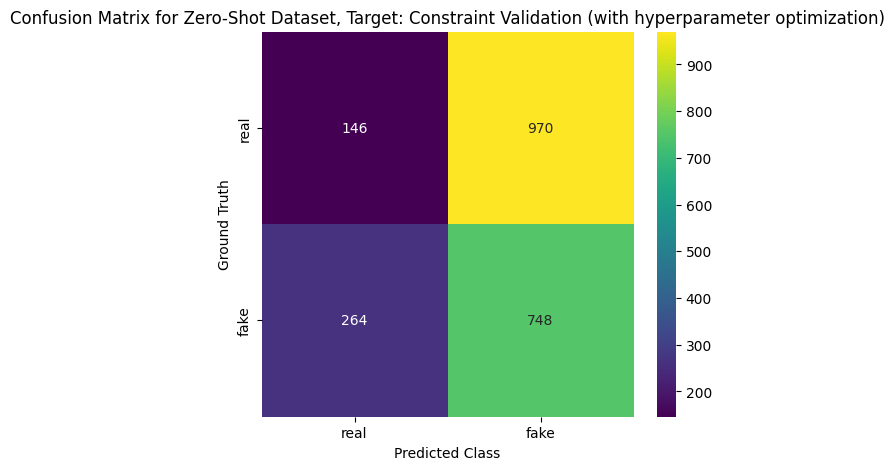

Accuracy: 0.4350
Precision (Macro): 0.4169
Recall (Macro): 0.4512
Macro F1-score: 0.3805

Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.13      0.20      1115
           1       0.44      0.77      0.56      1007

    accuracy                           0.43      2122
   macro avg       0.42      0.45      0.38      2122
weighted avg       0.42      0.43      0.37      2122



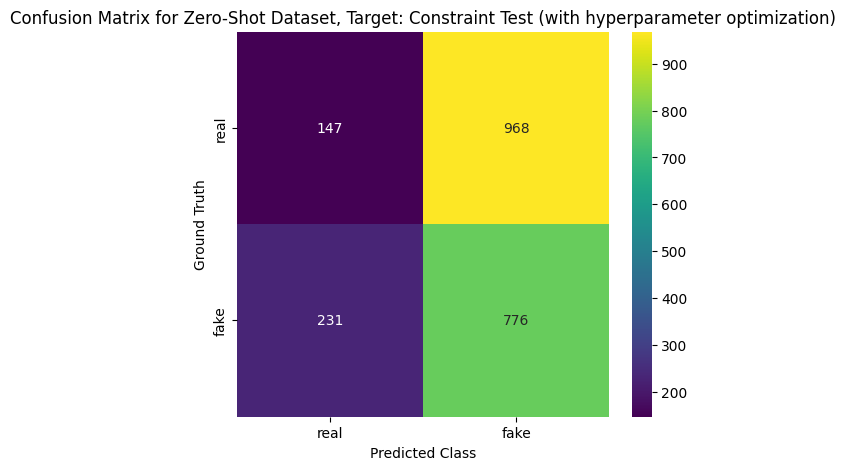

In [75]:
# Trains model with optimal hyperparams on zero-shot mixed dataset with zero Constraint samples
zero_shot_target_ct_model = trainModel(
    ct_target_zero_shot_train_basic_feature_df, # Constraint target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Zero_Shot_Constraint_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on Constraint target validation set
zero_shot_target_ct_val_dict = evaluateModel(zero_shot_target_ct_model, ct_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: Constraint Validation (with hyperparameter optimization)")

# Evaluates on Constraint target test set
zero_shot_target_ct_test_dict = evaluateModel(zero_shot_target_ct_model, ct_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: Constraint Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.4859
Precision (Macro): 0.4993
Recall (Macro): 0.4995
Macro F1-score: 0.4505

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.22      0.31      1116
           1       0.48      0.78      0.59      1012

    accuracy                           0.49      2128
   macro avg       0.50      0.50      0.45      2128
weighted avg       0.50      0.49      0.44      2128



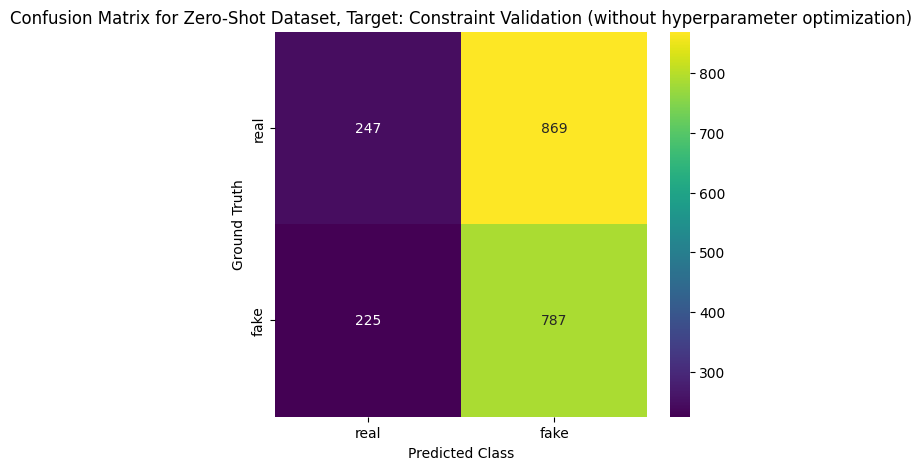

Accuracy: 0.4826
Precision (Macro): 0.4951
Recall (Macro): 0.4966
Macro F1-score: 0.4479

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.22      0.31      1115
           1       0.47      0.77      0.59      1007

    accuracy                           0.48      2122
   macro avg       0.50      0.50      0.45      2122
weighted avg       0.50      0.48      0.44      2122



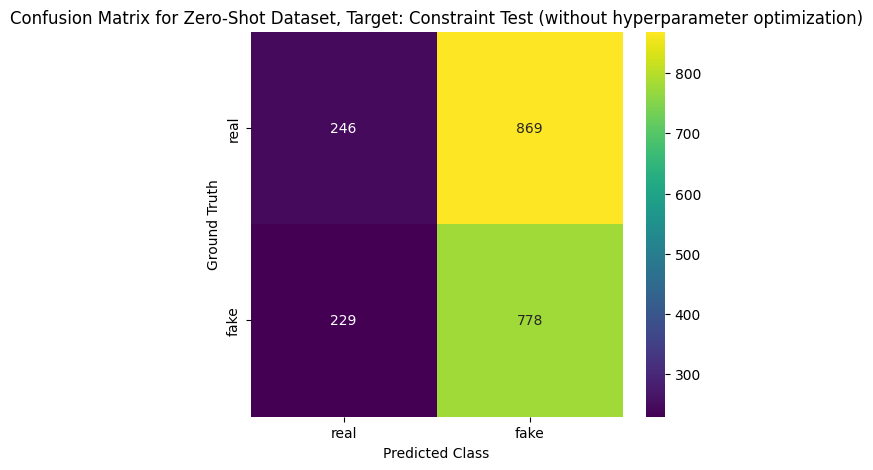

In [77]:
# Trains model withOUT optimal hyperparams on zero-shot mixed dataset with zero Constraint samples
zero_shot_target_ct_model = trainModelWithoutHyperparameterOptimization(
    ct_target_zero_shot_train_basic_feature_df, # Constraint target zero-shot training set
    extra_feature_columns
)

# Evaluates on Constraint target validation set
zero_shot_target_ct_val_dict = evaluateModel(zero_shot_target_ct_model, ct_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: Constraint Validation (without hyperparameter optimization)")

# Evaluates on Constraint target test set
zero_shot_target_ct_test_dict = evaluateModel(zero_shot_target_ct_model, ct_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: Constraint Test (without hyperparameter optimization)")

In [78]:
pf_target_zero_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Zero_Shot_PolitiFact_Target_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.6827
Precision (Macro): 0.6930
Recall (Macro): 0.6940
Macro F1-score: 0.6827

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.61      0.69        59
           1       0.60      0.78      0.68        45

    accuracy                           0.68       104
   macro avg       0.69      0.69      0.68       104
weighted avg       0.71      0.68      0.68       104



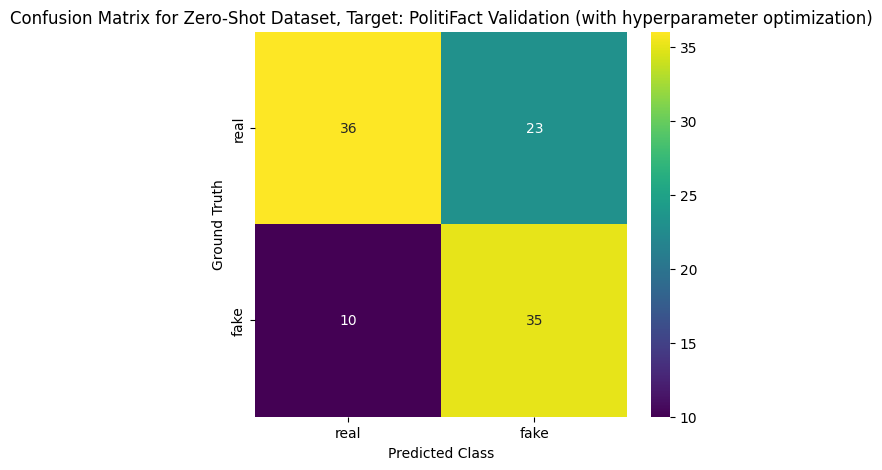

Accuracy: 0.5873
Precision (Macro): 0.5870
Recall (Macro): 0.5849
Macro F1-score: 0.5835

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        61
           1       0.59      0.66      0.62        65

    accuracy                           0.59       126
   macro avg       0.59      0.58      0.58       126
weighted avg       0.59      0.59      0.58       126



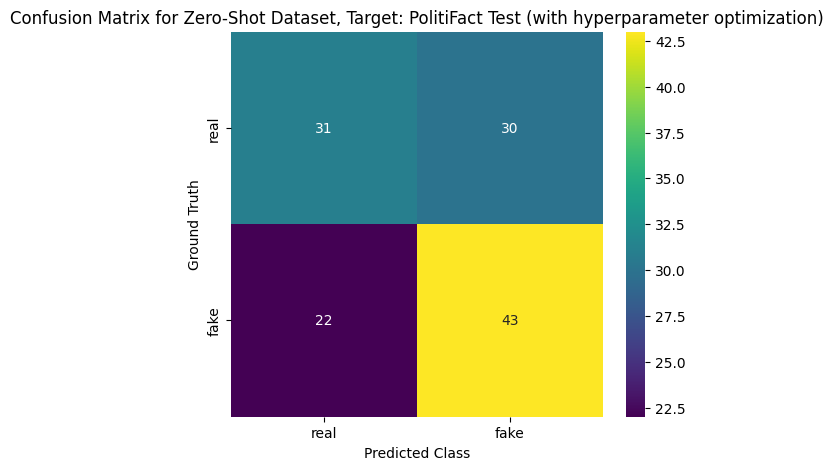

In [79]:
# Trains model with optimal hyperparams on zero-shot mixed dataset with zero PolitiFact samples
zero_shot_target_pf_model = trainModel(
    pf_target_zero_shot_train_basic_feature_df, # PolitiFact target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Zero_Shot_PolitiFact_Target", "Best Hyperparameters"]) # Pass in best params as dict
)

# Evaluates on PolitiFact target validation set
zero_shot_target_pf_val_dict = evaluateModel(zero_shot_target_pf_model, pf_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: PolitiFact Validation (with hyperparameter optimization)")

# Evaluates on PolitiFact target test set
zero_shot_target_pf_test_dict = evaluateModel(zero_shot_target_pf_model, pf_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: PolitiFact Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.6346
Precision (Macro): 0.6558
Recall (Macro): 0.6516
Macro F1-score: 0.6341

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.53      0.62        59
           1       0.56      0.78      0.65        45

    accuracy                           0.63       104
   macro avg       0.66      0.65      0.63       104
weighted avg       0.67      0.63      0.63       104



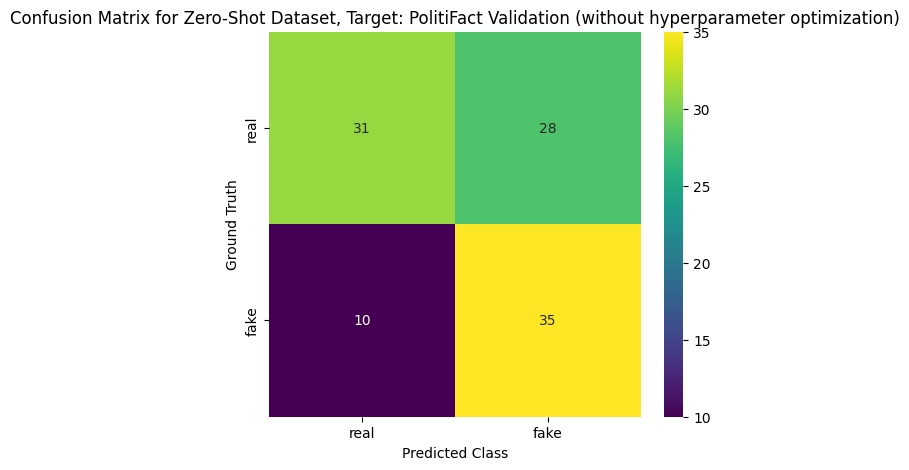

Accuracy: 0.6429
Precision (Macro): 0.6445
Recall (Macro): 0.6402
Macro F1-score: 0.6390

Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.56      0.60        61
           1       0.64      0.72      0.68        65

    accuracy                           0.64       126
   macro avg       0.64      0.64      0.64       126
weighted avg       0.64      0.64      0.64       126



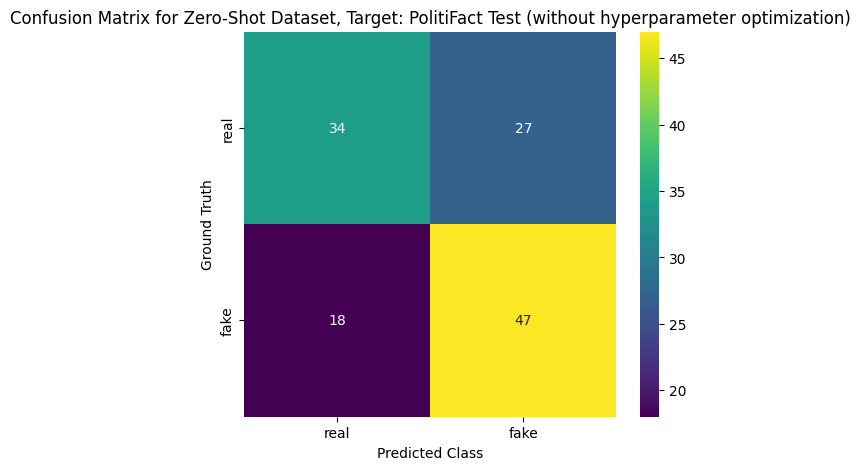

In [80]:
# Trains model withOUT optimal hyperparams on zero-shot mixed dataset with zero PolitiFact samples
zero_shot_target_pf_model = trainModelWithoutHyperparameterOptimization(
    pf_target_zero_shot_train_basic_feature_df, # PolitiFact target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction=
)

# Evaluates on PolitiFact target validation set
zero_shot_target_pf_val_dict = evaluateModel(zero_shot_target_pf_model, pf_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: PolitiFact Validation (without hyperparameter optimization)")

# Evaluates on PolitiFact target test set
zero_shot_target_pf_test_dict = evaluateModel(zero_shot_target_pf_model, pf_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: PolitiFact Test (without hyperparameter optimization)")

In [81]:
gc_target_zero_shot_train_basic_feature_df = pd.read_csv("../FPData/BasicFeatureExtractionDFs/Zero_Shot_GossipCop_Target_basic_features.csv")

Training the model...
Model training complete.
Accuracy: 0.4209
Precision (Macro): 0.5623
Recall (Macro): 0.5674
Macro F1-score: 0.4204

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.29      0.44      2018
           1       0.27      0.84      0.40       612

    accuracy                           0.42      2630
   macro avg       0.56      0.57      0.42      2630
weighted avg       0.72      0.42      0.43      2630



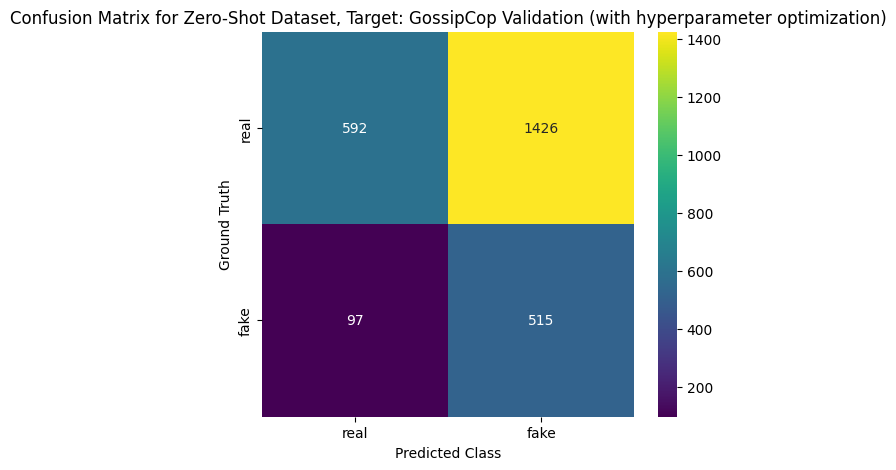

Accuracy: 0.4245
Precision (Macro): 0.5580
Recall (Macro): 0.5634
Macro F1-score: 0.4238

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.30      0.44      2444
           1       0.27      0.83      0.40       755

    accuracy                           0.42      3199
   macro avg       0.56      0.56      0.42      3199
weighted avg       0.71      0.42      0.43      3199



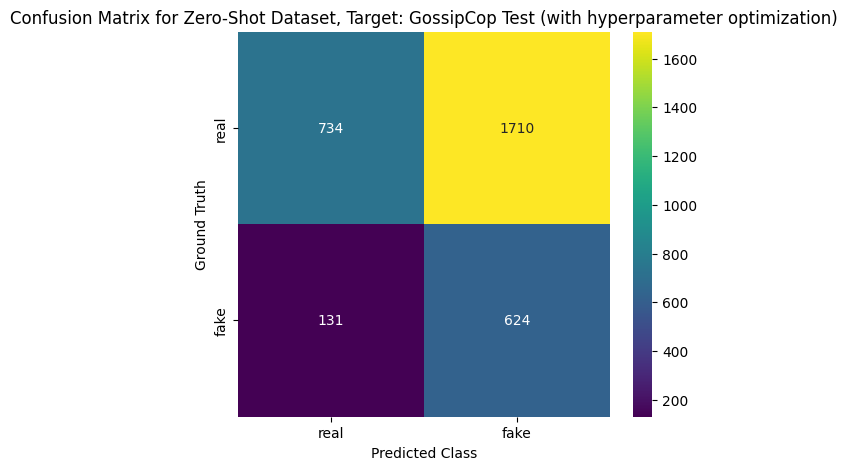

In [82]:
# Trains model with optimal hyperparams on zero-shot mixed dataset with zero GossipCop samples
zero_shot_target_gc_model = trainModel(
    gc_target_zero_shot_train_basic_feature_df, # GossipCop target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
    dict(hyperparameter_optimization_results_df.loc["Zero_Shot_GossipCop_Target", "Best Hyperparameters"]) # Passes in best hyperparams
)

# Evaluates on GossipCop target validation set
zero_shot_target_gc_val_dict = evaluateModel(zero_shot_target_gc_model, gc_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: GossipCop Validation (with hyperparameter optimization)")

# Evaluates on GossipCop target test set
zero_shot_target_gc_test_dict = evaluateModel(zero_shot_target_gc_model, gc_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: GossipCop Test (with hyperparameter optimization)")

Training PAC model with NO hyperparameter optimization for few-shot and zero-shot evaluation scenarios...
Accuracy: 0.4920
Precision (Macro): 0.5697
Recall (Macro): 0.5904
Macro F1-score: 0.4831

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.41      0.55      2018
           1       0.28      0.77      0.42       612

    accuracy                           0.49      2630
   macro avg       0.57      0.59      0.48      2630
weighted avg       0.72      0.49      0.52      2630



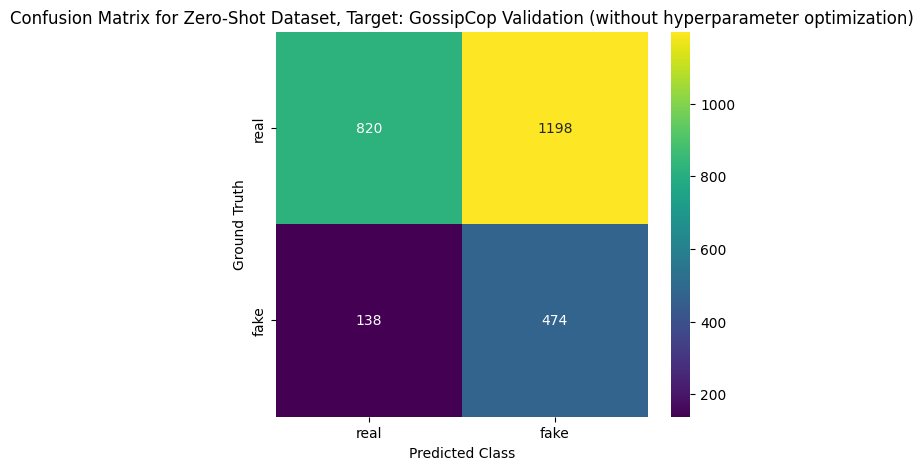

Accuracy: 0.4802
Precision (Macro): 0.5517
Recall (Macro): 0.5669
Macro F1-score: 0.4705

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.40      0.54      2444
           1       0.27      0.73      0.40       755

    accuracy                           0.48      3199
   macro avg       0.55      0.57      0.47      3199
weighted avg       0.70      0.48      0.51      3199



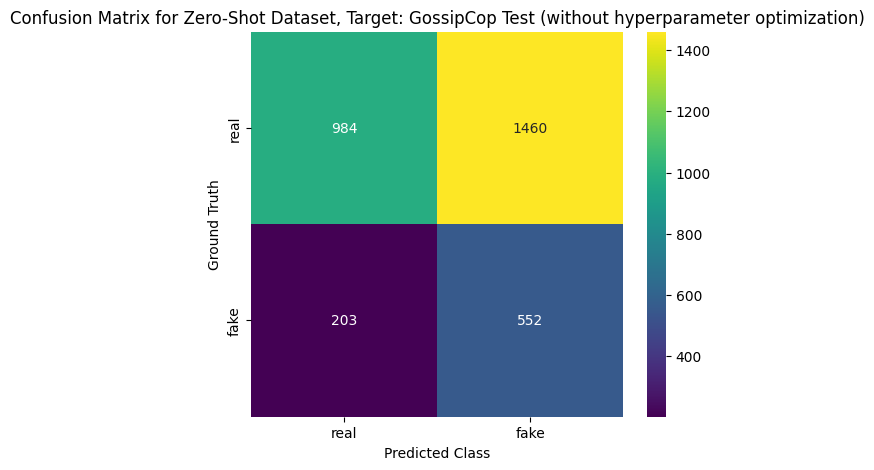

In [83]:
# Trains model withOUT optimal hyperparams on zero-shot mixed dataset with zero GossipCop samples
zero_shot_target_gc_model = trainModelWithoutHyperparameterOptimization(
    gc_target_zero_shot_train_basic_feature_df, # GossipCop target zero-shot training set
    extra_feature_columns, # List of extra feature column names for Column Transformer extraction
)

# Evaluates on GossipCop target validation set
zero_shot_target_gc_val_dict = evaluateModel(zero_shot_target_gc_model, gc_val_basic_feature_df, extra_feature_columns,
                                         "Zero-Shot Dataset, Target: GossipCop Validation (without hyperparameter optimization)")

# Evaluates on GossipCop target test set
zero_shot_target_gc_test_dict = evaluateModel(zero_shot_target_gc_model, gc_test_basic_feature_df, extra_feature_columns,
                                             "Zero-Shot Dataset, Target: GossipCop Test (without hyperparameter optimization)")

## Results for TF-IDF, Engineered Features and Passive-Aggressive Classifier

## Full-Scale Evaluation Scenario: Best Results

| Dataset (Set)          | Hyperparameters Optimized? | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|------------------------|--------------------------|----------|-------------------|---------------|---------------|
| WELFake (Validation)   | Yes                      | 0.9645   | 0.9621   | 0.9652   | 0.9636   |
| WELFake (Test)         | Yes                      | 0.9652   | 0.9606   | 0.9663   | 0.9633   |
| Fakeddit (Validation)  | No                       | 0.8630   | 0.8627   | 0.8588   | 0.8604   |
| Fakeddit (Test)        | No                       | 0.8638   | 0.8630   | 0.8597   | 0.8611   |
| Constraint (Validation)| Yes                      | 0.9474   | 0.9479   | 0.9467   | 0.9472   |
| Constraint (Test)      | Yes                      | 0.9467   | 0.9469   | 0.9463   | 0.9466   |
| PolitiFact (Validation)| Yes                      | 0.8846   | 0.8861   | 0.8930   | 0.8842   |
| PolitiFact (Test)      | No                       | 0.8651   | 0.8667   | 0.8662   | 0.8651   |
| GossipCop (Validation) | No                       | 0.8616   | 0.8404   | 0.7459   | 0.7773   |
| GossipCop (Test)       | No                       | 0.8540   | 0.8226   | 0.7443   | 0.7716   |
| All-Four (Validation)  | No                       | 0.9254   | 0.9237   | 0.9188   | 0.9211   |
| All-Four (Test)        | No                       | 0.9267   | 0.9233   | 0.9178   | 0.9204   |

## Five-Shot Evaluation Scenario: Best Results

| Dataset (Set)               | Hyperparameters Optimized? | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-----------------------------|----------------------------|----------|-------------------|----------------|----------------|
| WELFake (Validation)        | Yes                        | 0.6109   | 0.5962            | 0.5938         | 0.5944         |
| WELFake (Test)              | Yes                        | 0.6298   | 0.6068            | 0.6068         | 0.6068         |
| Constraint (Validation)     | Yes                        | 0.4840   | 0.4969            | 0.4979         | 0.4468         |
| Constraint (Test)           | Yes                        | 0.4826   | 0.4949            | 0.4964         | 0.4490         |
| PolitiFact (Validation)     | Yes                        | 0.6635   | 0.6735            | 0.6744         | 0.6634         |
| PolitiFact (Test)           | No                         | 0.6635   | 0.6696            | 0.6718         | 0.6632         |
| GossipCop (Validation)      | No                         | 0.4768   | 0.5722            | 0.5902         | 0.4711         |
| GossipCop (Test)            | No                         | 0.4626   | 0.5564            | 0.5696         | 0.4574         |


## Zero-Shot Evaluation Scenario: Best Results

| Dataset (Set)               | Hyperparameters Optimized? | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |
|-----------------------------|----------------------------|----------|-------------------|----------------|----------------|
| WELFake (Validation)        | Yes                        | 0.6093 | 0.5940        | 0.5912    | 0.5918         |
| WELFake (Test)              | Yes                        | 0.6269 | 0.6032        | 0.6028    | 0.6030         |
| Constraint (Validation)     | No                         | 0.4859   | 0.4993            | 0.4995         | 0.4505         |
| Constraint (Test)           | No                         | 0.4826   | 0.4951            | 0.4966         | 0.4479         |
| PolitiFact (Validation)     | Yes                        | 0.6827   | 0.6930            | 0.6940         | 0.6827         |
| PolitiFact (Test)           | No                         | 0.6429   | 0.6445            | 0.6402         | 0.6390         |
| GossipCop (Validation)      | No                         | 0.4920   | 0.5697            | 0.5904         | 0.4831         |
| GossipCop (Test)            | No                         | 0.4802   | 0.5517            | 0.5669         | 0.4705         |


## Interpretation of Results Following Feature Extraction and Hyperparameter Tuning

### Full-Scale Evaluation Scenario:

- Slight improvements across F1-score when compared to baseline scores
- WELFake F1-score increased from 94% to 96%
- Fakeddit F1-score increased from 81% to 86%
- Constraint increase in F1-score was minimal (from 94% to 95%)
- PolitiFact: no change
- GossipCop increase from 75% to 78%
- All-four combined: increase from 88% to 92% (when no hyperparameter optimization applied - but this model is VERY large and hence not possible to upload onto Streamlit; hence the optimized, smaller model with be used for user testing at the expense of -2% F1-score)

### Five-Shot Evaluation Scenario:
- Slight increase for PolitiFact and GossipCop targets, but unfortunately no change/minor decrease for the other two
- WELFake performance decreased from F1-score of 59.8% for baseline to 59.4% when optimized


### Zero-Shot Evaluation Scenario
- Decreased compared to baseline for WELFake, Constraint
- Increased compared to baseline by 5% for PolitiFact (optimized) and for GossipCop (non-optimized)

### Summary
- Feature extraction and hyperparameter tuning was not successful for few-shot and zero-shot evaluation on the two challenging Constraint and GossipCop datasets, probably due to overfitting/overtuning to the training data which contained few or no samples of the target dataset
- Better generalizability between WELFake and PolitiFact may be attributed to the fact that data samples come from the same domain (topic), i.e. political news and general current affairs, while Constraint contains health news and GossipCop entertainment news
- As a result, extensive hyperparameter tuning may not be ideal in a few-shot and zero-shot scenario due to overtuning to the training set
- Shows the challenge of using traditional machine-learning models for generalization across domains/news topics